<a href="https://colab.research.google.com/github/Solomorning/hse22_project/blob/main/Mening_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [2]:
!conda install -c bioconda pybedtools -y
!pip install gtfparse
!pip install biopython

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pybedtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bedtools-2.30.0            |       h468198e_3        15.5 MB  bioconda
    c-ares-1.18.1              |       h7f98852_0         113 KB  conda-forge
    ca-certificates-2022.5.18.1|       ha878542_0         144 KB  conda-forge
    certifi-2022.5.18.1        |   py37h89c1867_0         150 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    cudatoolkit-11.1.1         |      ha002fc5_10        1.20 GB  conda-forge
    keyutils-1.6.1             |

In [3]:
!conda install -c bioconda dna_features_viewer -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - dna_features_viewer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.79             |   py37h5e8e339_1         2.6 MB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    dna_features_viewer-3.1.1  |     pyh5e36f6f_0          29 KB  bioconda
    freetype-2.10.4            |       h0708190_1         890 KB  conda-forge
    jpeg-9e                    |       h166bdaf_1         268 KB  conda-forge
    kiwisolver-1.4.3           |   py37h7cecad7_0          73 KB  conda-forge
    libpng-1.6.37              |       h211

In [4]:
!apt-get install proteinortho

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  ncbi-blast+ ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data proteinortho
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 13.2 MB of archives.
After this operation, 67.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ncbi-data all 6.1.20170106-2 [3,645 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ncbi-blast+ amd64 2.6.0-1 [9,446 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proteinortho amd64 5.16+dfsg-1 [143 kB]
Fetched 13.2 MB in 0s (48.5 MB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 155632 files and directories current

In [1]:
import subprocess
import shutil
import urllib.request as request
import asyncio
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt


from pybedtools import BedTool
from contextlib import closing
from Bio import Entrez, SeqIO
from multiprocessing.pool import ThreadPool
from dataclasses import dataclass, InitVar
from gtfparse import read_gtf
from pathlib import Path
from dna_features_viewer import GraphicFeature, GraphicRecord

**Часть 1 - скачивание**


Для начала куча импортов и лист с оргаизмами - все ж таки надо с чем-то работать

In [2]:
orgnames = '''Candidatus Methanoplasma termitum
Cuniculiplasma divulgatum
Ferroplasma acidarmanus fer1
Picrophilus torridus DSM 9790
Thermoplasma acidophilum DSM 1728'''

In [3]:
orgnames = orgnames.split('\n')

In [5]:
Entrez.email = "simerning@gmail.com"

Для хранения информации о сборке класс AsseblyInfo

In [6]:
@dataclass
class AssInfo:
    ass_acc: str
    ass_name: str
    org: str
    taxid: str
    link: str
    date: str

    @property
    def gtf(self) -> str:
        return f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.gtf.gz'
    @property
    def fasta(self) -> str:
        return f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.fna.gz'
    @property
    def ft(self) -> str:
        return f'{self.link}/{self.ass_acc}_{self.ass_name}_feature_table.txt.gz'
    @property
    def gbff(self) -> str:
        return f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.gbff.gz'
    @property
    def pfa(self) -> str:
        return f'{self.link}/{self.ass_acc}_{self.ass_name}_protein.faa.gz'    
    @gtf.setter
    def wheels(self, gtf: str):
        self.gtf = f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.gtf.gz' 
    @fasta.setter
    def wheels(self, fasta: str):
        self.fasta = f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.fna.gz'   
    @ft.setter
    def wheels(self, ft: str):
        self.ft = f'{self.link}/{self.ass_acc}_{self.ass_name}_feature_table.txt.gz'
    @gbff.setter
    def wheels(self, gtf: str):
        self.gtf = f'{self.link}/{self.ass_acc}_{self.ass_name}_genomic.gbff.gz' 
    @pfa.setter
    def wheels(self, gtf: str):
        self.gtf = f'{self.link}/{self.ass_acc}_{self.ass_name}_protein.faa.gz' 

Функции для скачивания фтпшек и параллелинга всего этого

In [7]:
def multithreadizer(func):
    def wrapper(args: list, th_num: int = 0):
        if not th_num:
            th_num = len(args)
        ans = []
        vols = [th_num]*(len(args)//th_num) + [len(args)%th_num] if not len(args)%th_num else [th_num]*(len(args)//th_num)
        for i in vols:
            thread_pool = ThreadPool(th_num)
            ans = ans + thread_pool.starmap(func, args) 
        return ans
    return wrapper


@multithreadizer
def download_ftp(ftp_path, out_path):
    with closing(request.urlopen(ftp_path)) as ftp_blean:
        with open(out_path, 'wb') as file_blean:
            shutil.copyfileobj(ftp_blean, file_blean)
    return

Прекрасные (нет) eutils помогут получить ссылки на все файлы быстро. Вы же не думали, что я глазами буду в НЦБИ искать))). Работают, кстати, лет 300

In [8]:
def get_ftp(orgname):
    ftw = ['AssemblyAccession', 'AssemblyName', 'Organism', 'SpeciesTaxid', 'FtpPath_RefSeq', 'AsmReleaseDate_GenBank']
    handle = Entrez.esearch(db="assembly", term=f"{orgname}[ORGN]", idtype="acc")
    ids = Entrez.read(handle)['IdList']
    answ = []
    for i in ids:
        rec = Entrez.efetch(db="assembly", id=i, retmode="xml", rettype = 'docsum')
        rec = Entrez.read(rec)
        ans = [rec['DocumentSummarySet']['DocumentSummary'][0][i] for i in ftw]
        answ.append(AssInfo(*ans))
    return answ
def get_latest(assinfos):
    last = ''
    for i in assinfos:
        if i.date > last:
            last = i.date
            ans = i
    return ans
def get_infolist(orgnames):
    ans =  [get_latest(get_ftp(i)) for i in orgnames]
    return ans

Все приготовления завершены, можно и скачивать. Сразу создавем директорию data, новый класс позволяет не запутаться (или запутаться больше, тут уж каждый сам решает)

In [10]:
all_about_orgs = get_infolist(orgnames)

In [11]:
p = subprocess.Popen(f'mkdir data', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()

In [12]:
ftp_set_fasta = []
ftp_set_gtf = []
ftp_set_ft = []
ftp_set_gbff = []
ftp_prot_fa = []
for i in all_about_orgs:
    ftp_set_fasta.append((i.fasta, f'data/{i.ass_acc}_{i.ass_name}.fasta.gz'))
    ftp_set_gtf.append((i.gtf, f'data/{i.ass_acc}_{i.ass_name}.gtf.gz'))
    ftp_set_ft.append((i.ft, f'data/{i.ass_acc}_{i.ass_name}.ft.gz'))
    ftp_set_gbff.append((i.gbff, f'data/{i.ass_acc}_{i.ass_name}.gbff.gz'))
    ftp_prot_fa.append((i.pfa, f'data/{i.ass_acc}_{i.ass_name}.prot_fasta.faa.gz'))
    

In [13]:
download_ftp(ftp_set_fasta)
download_ftp(ftp_set_gtf)
download_ftp(ftp_set_ft)
download_ftp(ftp_set_gbff)
download_ftp(ftp_prot_fa)

[None, None, None, None, None, None, None, None, None, None]

Все скачано, можно и распаковать

In [14]:
p = subprocess.Popen('gunzip data/*.gz', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
out, err

(b'', b'')

Ну и заодно скачаю zhunter. Удачной охоты, Йен)

In [15]:
zhlink = 'https://raw.githubusercontent.com/vanya-antonov/hse22-project/main/zhunt3-alan.c'

p = subprocess.Popen(f'wget {zhlink}', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()

p = subprocess.Popen(f'gcc zhunt3-alan.c -lm -o zhunt3', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()

**Действие второе - пляски с аннотацией**

просто читаем таблицчку с аннотацией

In [16]:
fts = dict()
for i in all_about_orgs:
    fts[f'{i.ass_acc}_{i.ass_name}'] = pd.read_csv(f'data/{i.ass_acc}_{i.ass_name}.ft', sep='\t')

Читаем фасту, сразу записываем айдишники, на этот раз хромосом, кольцевых, коих у наших бактерий ровно по одной

In [17]:
def open_fasta(filename):
  ans = SeqIO.parse(filename,'fasta')
  return ans

In [18]:
id_to_len = dict()
id_to_ac = dict()
for i in all_about_orgs:
  for j in open_fasta(f'data/{i.ass_acc}_{i.ass_name}.fasta'):
    id_to_len[j.id] = len(j.seq)
    id_to_ac[j.id] = f'{i.ass_acc}_{i.ass_name}'

Так как бэдтулс НЕ умеет работать с кольцевыми послежовательностями, разбиваем гены, которым не повезло попасть на начало отсчета на пару частей, заодно запоминаем их количество

In [19]:
def circulizer(df, lens):
  df.reset_index(inplace = True, drop = True)
  bad = df[df.start>df.end].index
  to_app = {i:[] for i in df.columns}
  for i in bad:
    st, en, ac = df.loc[i, 'start'], df.loc[i, 'end'], df.loc[i, 'genomic_accession']
    to_app['start'].append(1)
    to_app['end'].append(en)
    to_app['genomic_accession'].append(ac)
    to_app['start'].append(st)
    to_app['end'].append(lens[ac])
    to_app['genomic_accession'].append(ac)
    for h in df.columns[3:]:
      to_app[h].append(df.loc[i, h])
      to_app[h].append(df.loc[i, h])
  df2 = pd.DataFrame(to_app)
  df = df.append(df2, ignore_index=True)
  df.drop(bad, inplace = True)
  return df


Смержим гены, чтобы посчитать покрытие

In [20]:
genes_merged = dict()
genes_num = dict()
for i in fts.keys():
  a = fts[i][fts[i].loc[:, '# feature'] == 'gene'].loc[:, ('genomic_accession', 'start', 'end')].reset_index(drop = True)
  genes_num[i] = len(fts[i].index)
  a = circulizer(a, id_to_len)
  a.sort_values(by = ['start', 'end'], inplace = True)
  a = a.astype({'start': 'int32', 'end': 'int32'})
  b = BedTool.from_dataframe(a)
  c = b.merge()
  del a 
  del b
  genes_merged[i] = c.to_dataframe()
  del c 

сосбвенно, подчет покрытия

In [21]:
total_len = {}
for i in genes_merged.keys():
  genes_merged[i].loc[:, 'len'] =  genes_merged[i].end - genes_merged[i].start
  total_len[i] = genes_merged[i].len.sum()
del genes_merged

**Часть 3 - Охота началась)**

Делаем функцию для запуска хантера (копируем из примера почти дословно)

In [22]:

ZH_EXECUTABLE = Path("./zhunt3")
assert ZH_EXECUTABLE.is_file()

def zhunt(query: str, windowsize: int = 6, minsize: int = 3, maxsize: int = 6, filename: int = 'query'):
    assert set(query).issubset({"A", "C", "G", "T", "N"})
    subprocess.Popen(f'touch {filename}', shell = True)
    with open(filename, 'w') as stream:
        stream.write(query)

    subprocess.run(
        ['./zhunt3', 
         str(windowsize), str(minsize), str(maxsize), filename],
        check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
        input=query, encoding='ascii'
    )
    with open(filename + ".Z-SCORE", 'r') as stream:
        df = pd.read_csv(stream,
                         names=['Start', 'End', 'nu-1', 'nu-2', 'nu-3', 
                                'ZH-Score', 'Sequence', 'Conformation'],
                         skiprows=1, sep='\s+')
    subprocess.Popen(f'rm {filename}', shell = True)
    subprocess.Popen(f'rm {filename}.Z-SCORE', shell = True)
    return df

Все, начинаем искать z-форму, попутно сохраняя в словарь очередные айдишники

In [23]:
ac_to_spi = dict()
zdna = dict()
for i in all_about_orgs:
  for j in open_fasta(f'data/{i.ass_acc}_{i.ass_name}.fasta'):
    zdna[j.id] = zhunt(str(j.seq), filename = j.id)
    ac_to_spi[j.id] = i.org

Фильтрация фрагментов с хорошим скором

In [24]:
zlarge = {}
for i in zdna.keys():
  zlarge[i] = zdna[i][zdna[i].loc[:, 'ZH-Score'] > 500]

И запись +- всего, что мы знаем о числе и длине фрагментов

In [25]:
totz = dict()
totzl = dict()
totzlen = dict()
totzllen = dict()
for i in zdna.keys():
  totz[i] = len(zdna[i].index)
  totzlen[i] = (zdna[i].End - zdna[i].Start).sum()
  totzl[i] = len(zlarge[i].index)
  totzllen[i] = (zlarge[i].End - zlarge[i].Start).sum()

In [26]:
for i in zlarge.keys():
  zlarge[i].to_csv(f'{ac_to_spi[i]}.tsv', sep = '\t', )

Мержим соседние фрагменты

In [27]:
z_mer = dict()
totzm = dict()
totzmlen = dict()
for i in zlarge.keys():
  zbed = zlarge[i].loc[:, ['Start', 'End', 'ZH-Score']]
  zbed.loc[:, 'chr'] = i
  totzm[i] = len(zbed.index)
  totzmlen[i] = (zbed.End - zbed.Start).sum()
  zbed = zbed.loc[:, ['chr', 'Start', 'End', 'ZH-Score']]
  zbed = BedTool.from_dataframe(zbed)
  zbed = zbed.merge(c = 4, o='max')
  z_mer[i] = zbed


**Часть 4 - о корреляциях**

для начала делаем большую табличку для кажжого организма. 
Может быть, я зануда, но во-первых, слоп не особо умеет в работу с кольцами, а во-вторых, я хочу безболезненно разделить 5' и 3' участки, все-таки, их функция сильно отличается. При разделении НЕ забываем, что для - цепи конец - это начало). Также я беру не гены, а рамки - ибо промотор все аннотируют по-разному, но мы все ж таки можем утверждать, что он находится недалеко от начала транскрипции (помню я про опероны, жаль, что они тут не обозначены и один ген - это 1 CDS)

In [28]:
beds_genes_full = {}
for i in fts.keys():
  beds_genes_full[i] = fts[i][fts[i].loc[:, '# feature'] == 'CDS'].loc[:, ('genomic_accession', 'start', 'end', 'product_accession','name', 'strand')].reset_index(drop = True)

In [29]:
def make_utrs(df, lens, lag = 100):
  df = df.astype({'product_accession': str})
  tUTR = df.copy()
  fUTR = df.copy() 
  fUTR.start = fUTR.apply(lambda x: (x[1]-lag)%lens[x[0]] if x[5]=='+' else x[2], axis = 1)
  fUTR.end = fUTR.apply(lambda x: (x[1]+lag)%lens[x[0]] if x[5]=='+' else (x[2] + lag)%lens[x[0]], axis = 1)
  fUTR.product_accession = fUTR.product_accession.apply(lambda x: x + ' 5UTR')
  tUTR.start = tUTR.apply(lambda x: x[2] if x[5]=='+' else (x[1]-lag)%lens[x[0]], axis = 1)
  tUTR.end = tUTR.apply(lambda x: (x[2]+lag)%lens[x[0]] if x[5]=='+' else (x[1]+lag)%lens[x[0]], axis = 1)
  tUTR.product_accession = tUTR.product_accession.apply(lambda x: x + ' 3UTR')
  df.product_accession = df.product_accession.apply(lambda x: x + ' gene')
  return pd.concat([df, fUTR, tUTR])

In [30]:
for i in beds_genes_full.keys():
  beds_genes_full[i] = make_utrs(beds_genes_full[i], id_to_len)

Ищем перекрывания все теми же бедтулс во внутрипитоновском имполнении. Заодно считаем суммарную длинц всех некодеров - пригодится

In [31]:
inter_frames = dict()
nonc_len = dict()
for i in z_mer.keys():
  b = circulizer(beds_genes_full[id_to_ac[i]], id_to_len)
  b = b.sort_values(by = ['start', 'end'])
  b = b.astype({'start': int, 'end': int})
  genes = BedTool.from_dataframe(b)
  a = genes.intersect(z_mer[i], wa=True, wb=True, F=0.7)
  a = a.to_dataframe()
  b = genes.merge()
  b = b.to_dataframe()
  b.loc[:,'sizes'] = b.end - b.start
  nonc_len[i] = id_to_len[i] - b.sizes.sum()
  inter_frames[i] = a

In [32]:
a

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,NC_002578.1,6957,8888,WP_083808292.1 gene,V-type ATP synthase subunit I,+,NC_002578.1,8253,8265,849.9296
1,NC_002578.1,10713,11651,WP_010900438.1 gene,NAD-dependent epimerase/dehydratase family pro...,-,NC_002578.1,11018,11030,779.1958
2,NC_002578.1,18448,18548,WP_010900448.1 5UTR,hypothetical protein,-,NC_002578.1,18515,18528,2752.4470
3,NC_002578.1,18513,18613,WP_010900449.1 5UTR,aminotransferase class I/II-fold pyridoxal pho...,+,NC_002578.1,18515,18528,2752.4470
4,NC_002578.1,19686,20456,WP_010900450.1 gene,D-aminoacyl-tRNA deacylase,+,NC_002578.1,20379,20393,980.0720
...,...,...,...,...,...,...,...,...,...,...
572,NC_002578.1,1554750,1554850,WP_010901899.1 3UTR,replication factor C small subunit,+,NC_002578.1,1554835,1554845,783.8230
573,NC_002578.1,1561593,1563164,WP_010901907.1 gene,AMP-binding protein,-,NC_002578.1,1561747,1561760,1201.6710
574,NC_002578.1,1561593,1563164,WP_010901907.1 gene,AMP-binding protein,-,NC_002578.1,1562423,1562435,583.0077
575,NC_002578.1,1563370,1564650,WP_048162191.1 gene,serine hydroxymethyltransferase,-,NC_002578.1,1563902,1563908,883.5764


разбиваем колонку, чтобы было легче определять тип участка

In [33]:
for i in inter_frames.keys():
  inter_frames[i].loc[:, 'type'] = inter_frames[i].name.apply(lambda x: x.split(' ')[1])
  inter_frames[i].name = inter_frames[i].name.apply(lambda x: x.split(' ')[0])

пампам. Считаем перекрывания

In [34]:
differ_types = {}
differ_size = {}
for i in inter_frames.keys():
  diftypes = pd.DataFrame(inter_frames[i].groupby(by = ('type')).size())
  diftypes.loc['noncoding', 0] = totzm[i] -  len(inter_frames[i].drop_duplicates(subset=('thickEnd', 'itemRgb')).index)
  differ_types[i] = diftypes
  inter_frames[i].loc[:, 'size'] = inter_frames[i].itemRgb	- inter_frames[i].thickEnd
  difsize = pd.DataFrame(inter_frames[i].loc[:, ('type', 'size')].groupby(by = ('type')).sum())
  difsize.loc['noncoding', 'size'] = totzmlen[i] -  inter_frames[i].drop_duplicates(subset=('thickEnd', 'itemRgb')).size.sum()
  differ_size[i] = difsize

делаем запрос для proteinortho и запускаем его же

In [35]:
names = []
for i in all_about_orgs:
  names.append(f'data/{i.ass_acc}_{i.ass_name}.prot_fasta.faa')

In [36]:
p = subprocess.Popen(f'''proteinortho5 {' '.join(names)} -project=data/protclus''', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
print(err.decode())

*****************************************************************
Proteinortho with PoFF version 5.16 - An orthology detection tool
*****************************************************************
Detected 2 available CPU threads, Detected NCBI BLAST version 2.6.0+
Checking input files
Checking data/GCF_000800805.1_ASM80080v1.prot_fasta.faa... ok
Checking data/GCF_900083515.1_ASM90008351v1.prot_fasta.faa... ok
Checking data/GCF_000152265.2_ASM15226v2.prot_fasta.faa... ok
Checking data/GCF_000008265.1_ASM826v1.prot_fasta.faa... ok
Checking data/GCF_000195915.1_ASM19591v1.prot_fasta.faa... ok

**Step 1**
Generating indices
Building database for 'data/GCF_900083515.1_ASM90008351v1.prot_fasta.faa'	(1900 sequences)
Building database for 'data/GCF_000152265.2_ASM15226v2.prot_fasta.faa'	(1863 sequences)
Building database for 'data/GCF_000008265.1_ASM826v1.prot_fasta.faa'	(1567 sequences)
Building database for 'data/GCF_000195915.1_ASM19591v1.prot_fasta.faa'	(1527 sequences)
Building database

In [37]:
prot_clusters = pd.read_csv('data/protclus.proteinortho', sep = '\t')

забираем себе топ-10 кластеров. Топовость - это то, сколько там видов и насколько они консервативны

In [38]:
to_vis = prot_clusters[prot_clusters.loc[:, '# Species']==5].sort_values(by = ['Alg.-Conn.', 'Genes'], ascending = False).iloc[:10, :]

И считаем огромную сводную таблицу из кучи массивов в самых разных местах

In [39]:
def make_summ(id_to_len, id_to_ac, genes_num, total_len, ac_to_spi, totz,  totzl,  totzlen, totzllen, totzm, totzmlen,  differ_types, differ_size, nonc_len):
  total = {i: [] for i in ['Specie', 
                           'Genome Length', 
                           'Total genes', 
                           'Summary genes length', 
                           'Genes coverage, %', 
                           'Total Z-dna number', 
                           'Total Z-dna length', 
                           'Total Z-dna filtered number', 
                           'Total Z-dna filtered length', 
                           'Total Z-dna merged number', 
                           'Total Z-dna merged length', 
                           'Z-dna in 5UTR, count', 
                           'Z-dna in 5UTR, total length', 
                           'Z-dna in 5UTR, average length',
                           'Z-dna in 5UTR, % length',
                           'Z-dna in 3UTR, count', 
                           'Z-dna in 3UTR, total length',
                           'Z-dna in 3UTR, average length',
                           'Z-dna in 3UTR, % length', 
                           'Z-dna in genes, count', 
                           'Z-dna in genes, total length',
                           'Z-dna in genes, average length',
                           'Z-dna in genes, % length', 
                           'Z-dna in NCR, count', 
                           'Z-dna in NCR, total length',
                           'Z-dna in NCR, average length',
                           'Z-dna in NCR, % length']}
  for i in id_to_len.keys():
    total['Specie'].append(ac_to_spi[i])
    total['Genome Length'].append(id_to_len[i])
    total['Total genes'].append(genes_num[id_to_ac[i]])
    total['Summary genes length'].append(total_len[id_to_ac[i]])
    total['Genes coverage, %'].append(total_len[id_to_ac[i]]/id_to_len[i] * 100)
    total['Total Z-dna number'].append(totz[i])
    total['Total Z-dna length'].append(totzlen[i])
    total['Total Z-dna filtered number'].append(totzl[i])
    total['Total Z-dna filtered length'].append(totzllen[i])
    total['Total Z-dna merged number'].append(totzm[i])
    total['Total Z-dna merged length'].append(totzmlen[i])
    total['Z-dna in 5UTR, count'].append(differ_types[i].loc['5UTR', 0])
    total['Z-dna in 5UTR, total length'].append(differ_size[i].loc['5UTR', 'size'])
    total['Z-dna in 5UTR, average length'].append(differ_size[i].loc['5UTR', 'size']/differ_types[i].loc['5UTR', 0])
    total['Z-dna in 5UTR, % length'].append(differ_size[i].loc['5UTR', 'size']/(genes_num[id_to_ac[i]] * 100)*100)
    total['Z-dna in 3UTR, count'].append(differ_types[i].loc['3UTR', 0])
    total['Z-dna in 3UTR, total length'].append(differ_size[i].loc['3UTR', 'size'])
    total['Z-dna in 3UTR, average length'].append(differ_size[i].loc['3UTR', 'size']/differ_types[i].loc['3UTR', 0])
    total['Z-dna in 3UTR, % length'].append(differ_size[i].loc['3UTR', 'size']/(genes_num[id_to_ac[i]] * 100)*100)
    total['Z-dna in genes, count'].append(differ_types[i].loc['gene', 0])
    total['Z-dna in genes, total length'].append(differ_size[i].loc['gene', 'size'])
    total['Z-dna in genes, average length'].append(differ_size[i].loc['gene', 'size']/differ_types[i].loc['gene', 0])
    total['Z-dna in genes, % length'].append(differ_size[i].loc['gene', 'size']/total_len[id_to_ac[i]])
    total['Z-dna in NCR, count'].append(differ_types[i].loc['noncoding', 0])
    total['Z-dna in NCR, total length'].append(differ_size[i].loc['noncoding', 'size'])
    total['Z-dna in NCR, average length'].append(differ_size[i].loc['noncoding', 'size']/differ_types[i].loc['noncoding', 0])
    total['Z-dna in NCR, % length'].append(differ_size[i].loc['noncoding', 'size']/nonc_len[i])
  return pd.DataFrame(total)



In [40]:
all_d = [id_to_len,
id_to_ac,
genes_num,
total_len,
ac_to_spi,
totz, 
totzl, 
totzlen,
totzllen,
totzm,
totzmlen, 
differ_types, 
differ_size,
nonc_len]
summ = make_summ(*all_d)
summ.to_csv('result_table.tsv', sep = '\t', index = False)
summ

,Specie,Genome Length,Total genes,Summary genes length,"Genes coverage, %",Total Z-dna number,Total Z-dna length,Total Z-dna filtered number,Total Z-dna filtered length,Total Z-dna merged number,...,"Z-dna in 3UTR, average length","Z-dna in 3UTR, % length","Z-dna in genes, count","Z-dna in genes, total length","Z-dna in genes, average length","Z-dna in genes, % length","Z-dna in NCR, count","Z-dna in NCR, total length","Z-dna in NCR, average length","Z-dna in NCR, % length"
0,Candidatus Methanoplasma termitum (archaea),1488669,2906,1349025,90.619540,1488669,13696428,2121,21574,2121,...,11.653846,0.208534,689.0,7899.0,11.464441,0.005855,1398.0,12898.0,9.226037,0.254293
1,Cuniculiplasma divulgatum (archaea),1938699,3920,1701677,87.774172,1938699,17248200,208,2082,208,...,11.000000,0.022449,69.0,759.0,11.000000,0.000446,131.0,1158.0,8.839695,0.012000
2,Ferroplasma acidarmanus fer1 (archaea),1935211,3912,1698170,87.751155,1935211,17277622,334,3386,334,...,11.300000,0.028885,117.0,1323.0,11.307692,0.000779,206.0,1850.0,8.980583,0.021201
3,Picrophilus torridus DSM 9790 (archaea),1545895,3252,1426655,92.286669,1545895,13734674,311,3114,311,...,11.500000,0.021218,130.0,1443.0,11.100000,0.001011,179.0,1530.0,8.547486,0.035889
4,Thermoplasma acidophilum DSM 1728 (archaea),1564906,3174,1380186,88.196096,1564906,14347314,1531,15492,1531,...,11.500000,0.152174,497.0,5650.0,11.368209,0.004094,1008.0,9216.0,9.142857,0.133852


**Часть последняя - картинки**

In [41]:
for i in z_mer.keys():
  z_mer[i] = z_mer[i].to_dataframe()

In [42]:
import matplotlib.gridspec as gridspec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


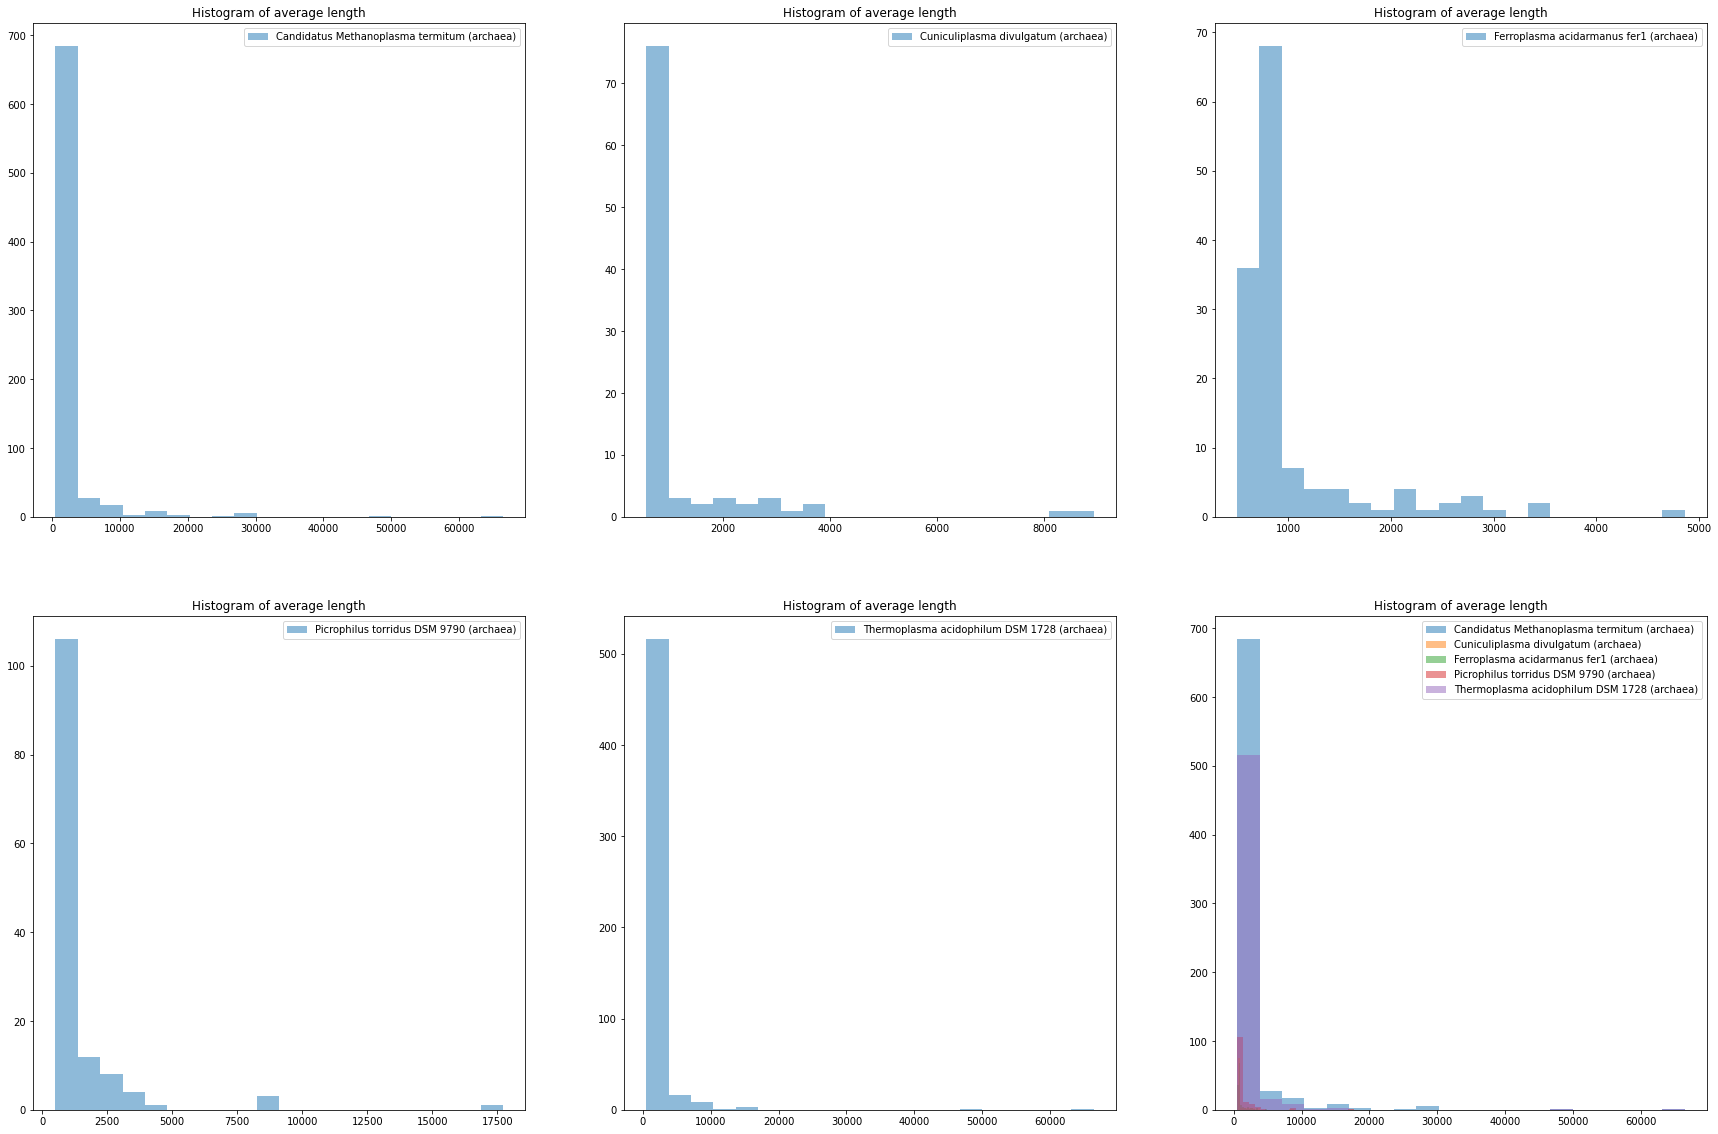

In [43]:
fig = plt.figure(1, figsize=(30, 20))
gs = gridspec.GridSpec(2, 3)
counter = 0
for i in z_mer.keys():
  ax0 = fig.add_subplot(gs[counter//3, counter%3])
  ax0.set_title(f'Histogram of average length')
  ax0.hist(z_mer[i].name, bins = 20, label = ac_to_spi[i], alpha = 0.5)
  ax0.legend()
  counter += 1
for i in z_mer.keys():
  ax0 = fig.add_subplot(gs[-1, -1])
  ax0.set_title(f'Histogram of average length')
  ax0.hist(z_mer[i].name, bins = 20, label = ac_to_spi[i], alpha = 0.5)
  ax0.legend()
plt.savefig('all_lengthhis.png')
plt.show()

In [44]:
?plt.hist(x)

In [45]:
notannot = dict()
for i in z_mer.keys():
  a = z_mer[i].merge(inter_frames[i], how = 'outer', left_on = ['start', 'end'], right_on = ['thickEnd', 'itemRgb'])
  notannot[i] = a[a.score.isna()].loc[:, ['chrom_x', 'start_x', 'end_x',	'name_x']]

In [49]:
for u in beds_genes_full.keys():
  beds_genes_full[u].product_accession	= beds_genes_full[u].product_accession.apply(lambda x: x.split(' ')[0])

[GF(diaminopimelate decarboxylase, 14769-16028 (1)), GF(zDNA, 15109-15121 )]
[GF(diaminopimelate decarboxylase, 1625147-1626412 (-1)), GF(zDNA, 1626455-1626467 )]
[GF(diaminopimelate decarboxylase, 835742-836950 (-1))]
[GF(diaminopimelate decarboxylase, 87330-88586 (1)), GF(zDNA, 87861-87873 ), GF(zDNA, 88157-88165 )]
[GF(diaminopimelate decarboxylase, 1617709-1619004 (-1))]


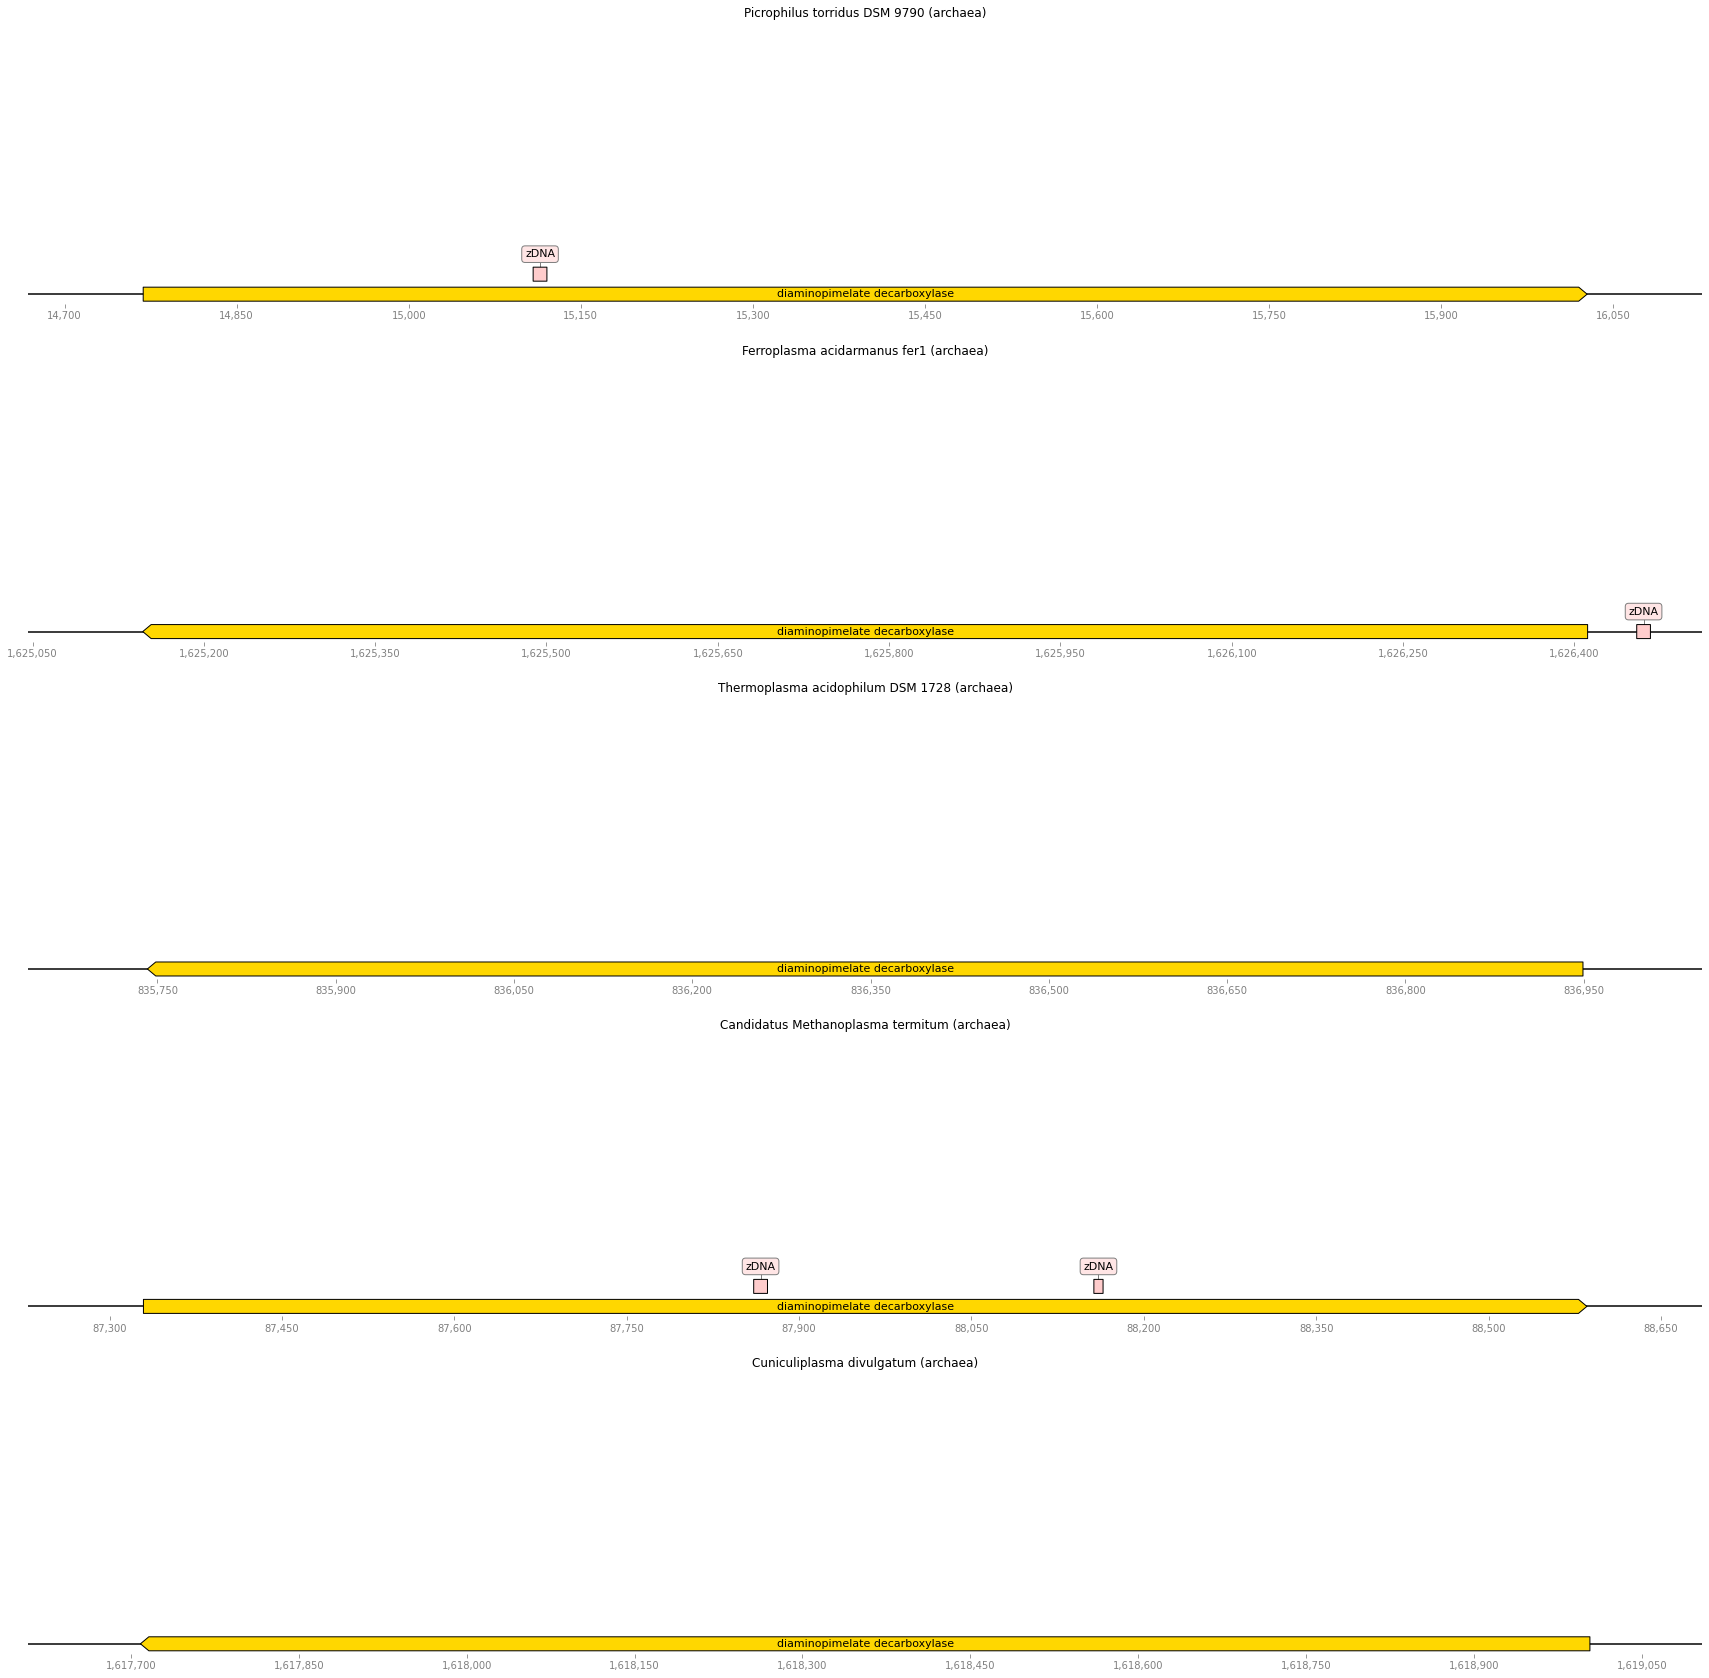

[GF(cysteine--tRNA ligase, 96931-98298 (1))]
[GF(cysteine--tRNA ligase, 1841318-1842688 (1))]
[GF(cysteine--tRNA ligase, 1218512-1219870 (-1))]
[GF(cysteine--tRNA ligase, 692176-693582 (-1)), GF(zDNA, 693493-693507 )]
[GF(cysteine--tRNA ligase, 1108598-1109968 (-1))]


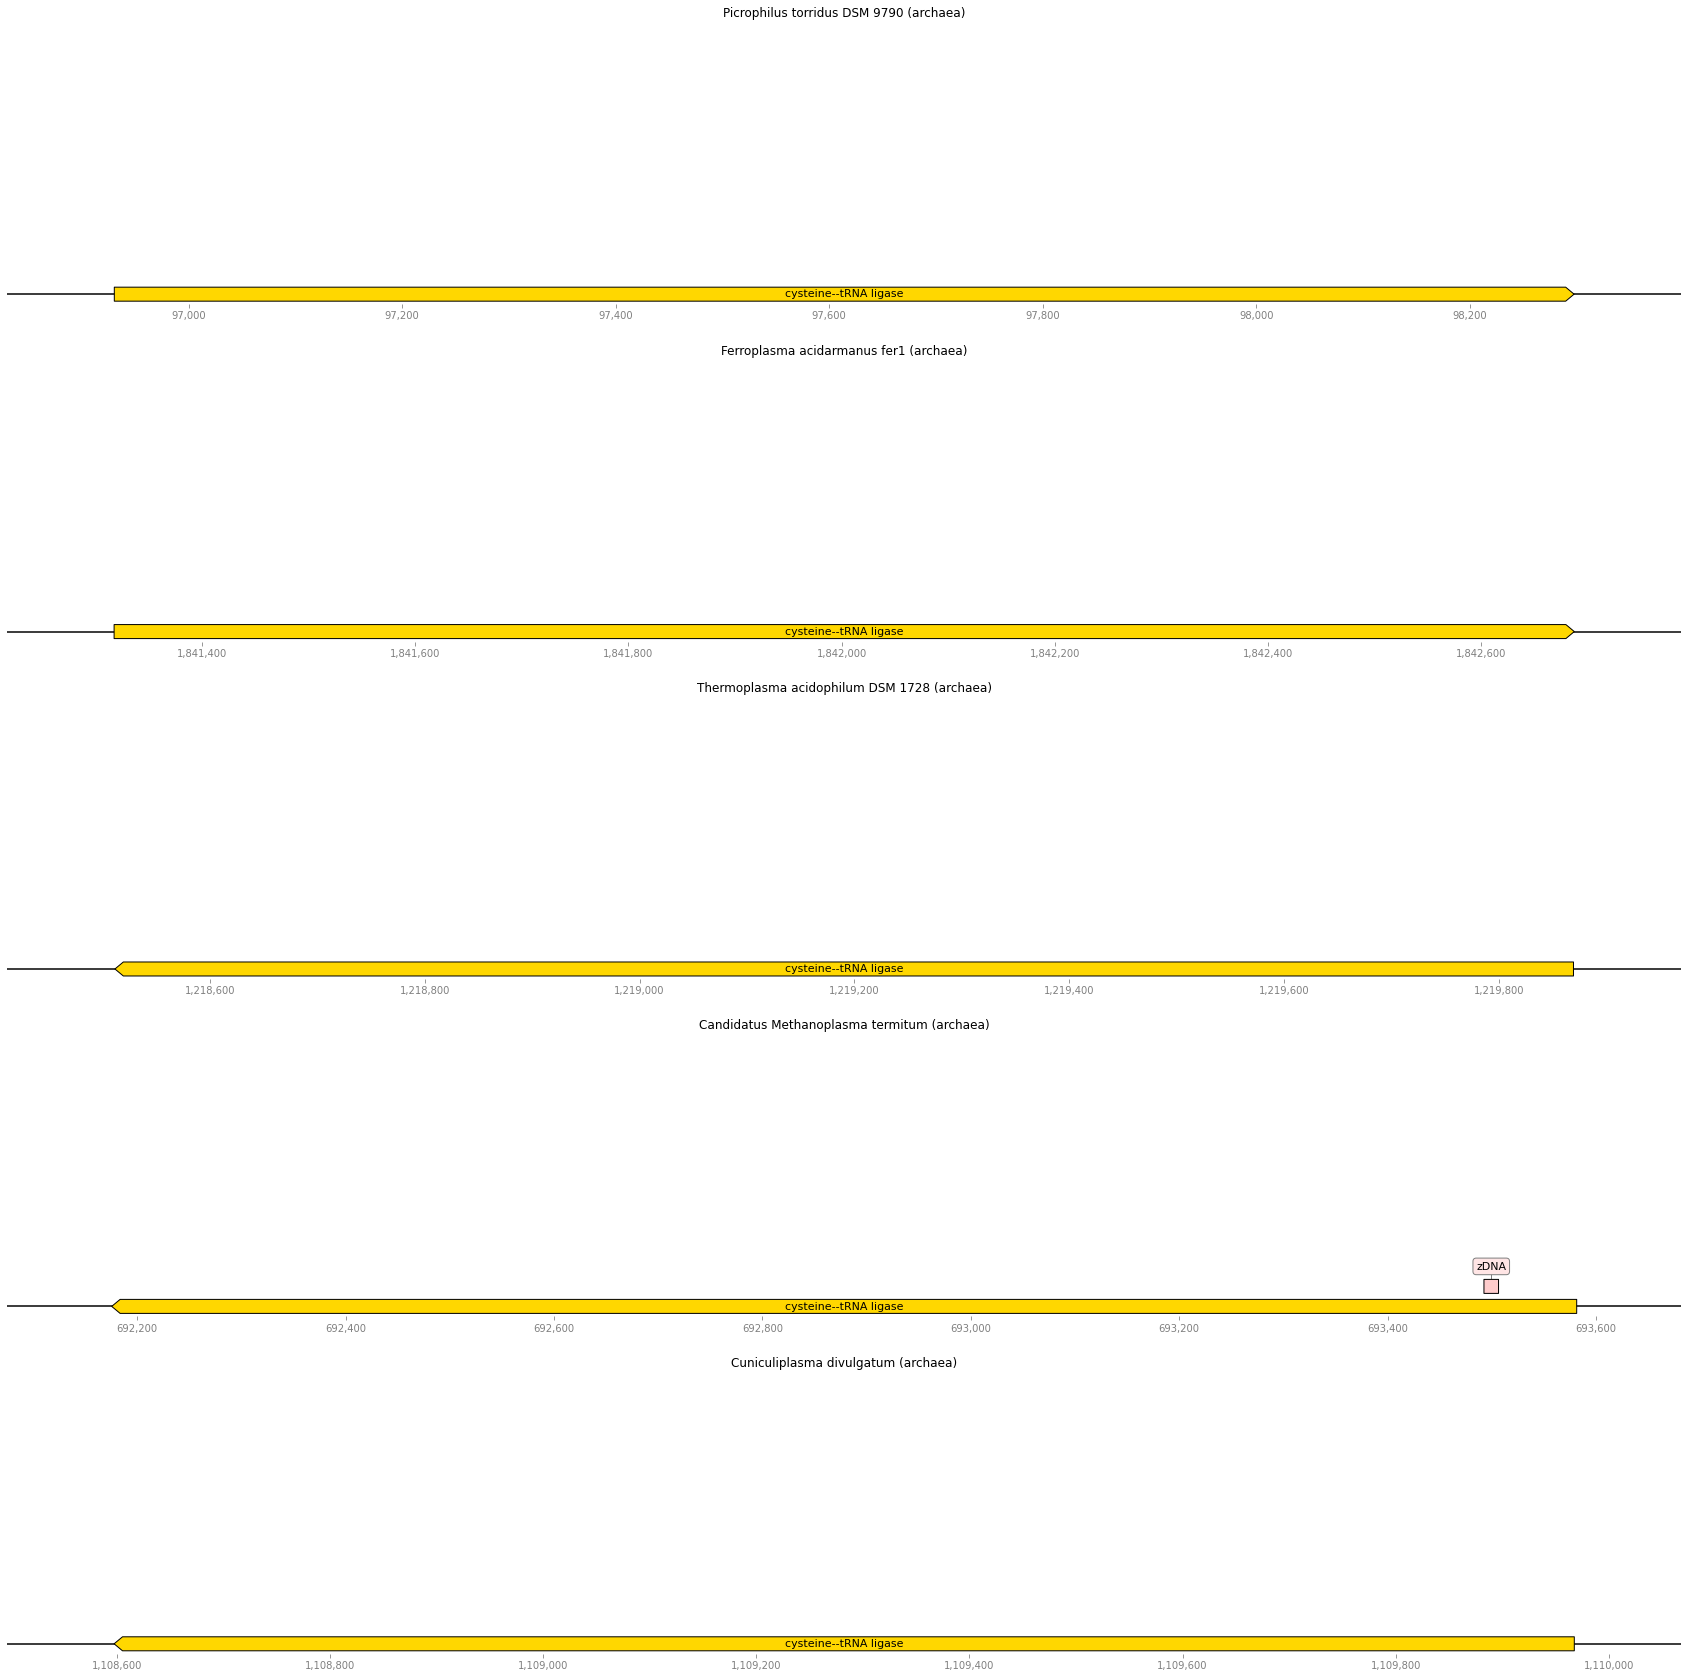

[GF(YbhB/YbcL family Raf kinase inhibitor-like protein, 115333-115770 (1)), GF(zDNA, 115613-115625 )]
[GF(YbhB/YbcL family Raf kinase inhibitor-like protein, 1349007-1349459 (1))]
[GF(YbhB/YbcL family Raf kinase inhibitor-like protein, 1156836-1157321 (-1))]
[GF(YbhB/YbcL family Raf kinase inhibitor-like protein, 165795-166271 (1)), GF(zDNA, 166330-166340 )]
[GF(YbhB/YbcL family Raf kinase inhibitor-like protein, 1251745-1252209 (1))]


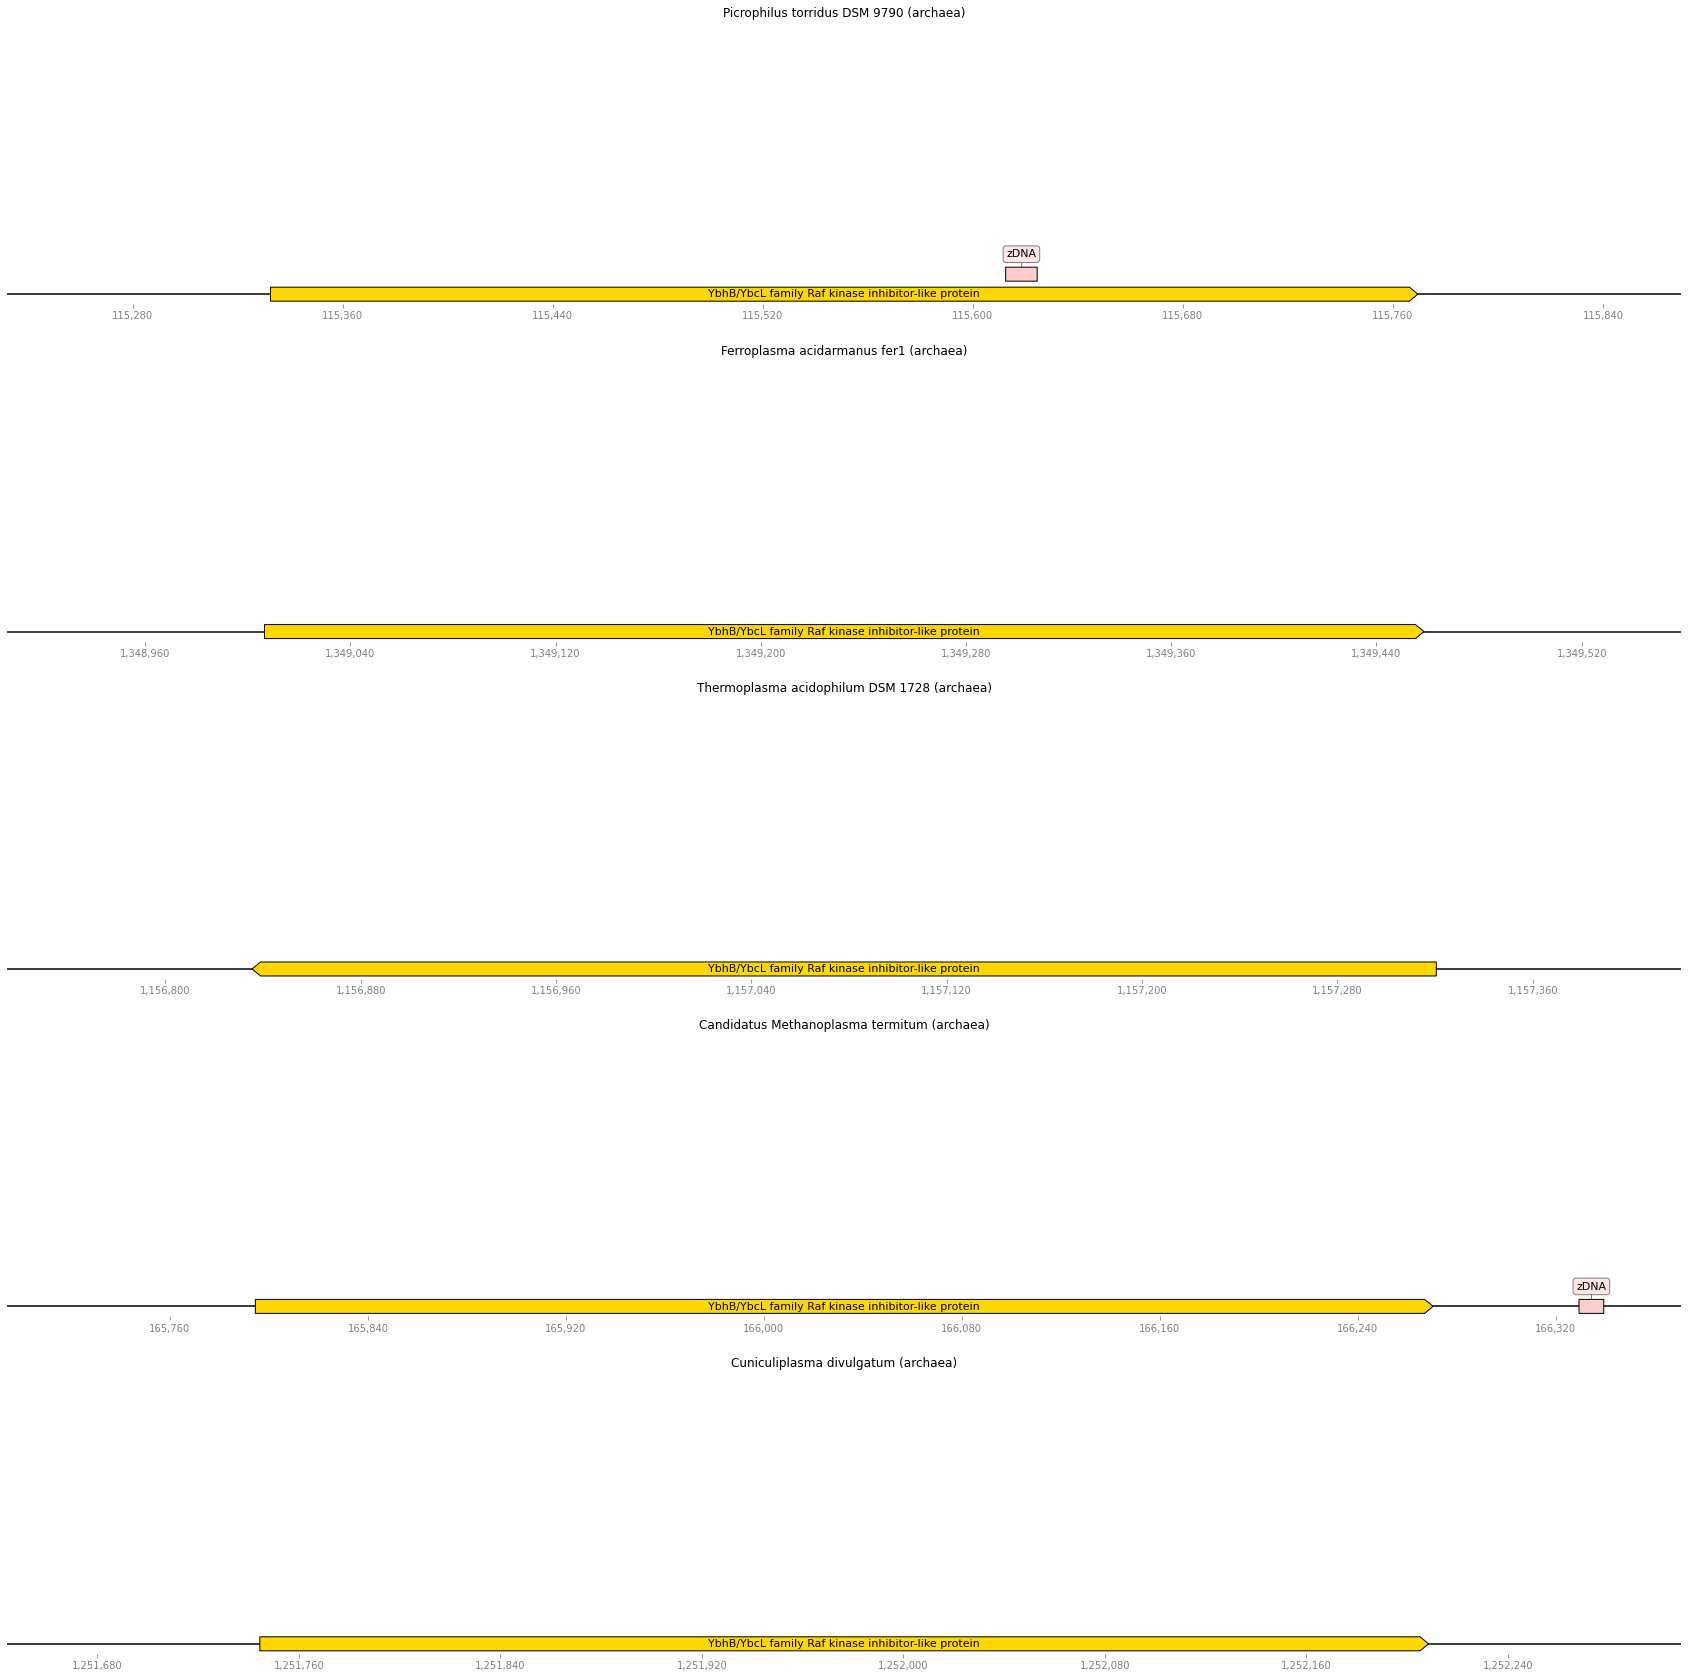

[GF(cobyrinate a,c-diamide synthase, 126994-128316 (-1))]
[GF(cobyrinate a,c-diamide synthase, 1801084-1802445 (1))]
[GF(cobyrinate a,c-diamide synthase, 1270438-1271769 (-1))]
[GF(hydrogenobyrinic acid a,c-diamide synthase (glutamine-hydrolyzing), 536552-537907 (-1)), GF(zDNA, 537508-537520 )]
[GF(cobyrinate a,c-diamide synthase, 1854627-1855889 (1)), GF(zDNA, 1855830-1855844 )]


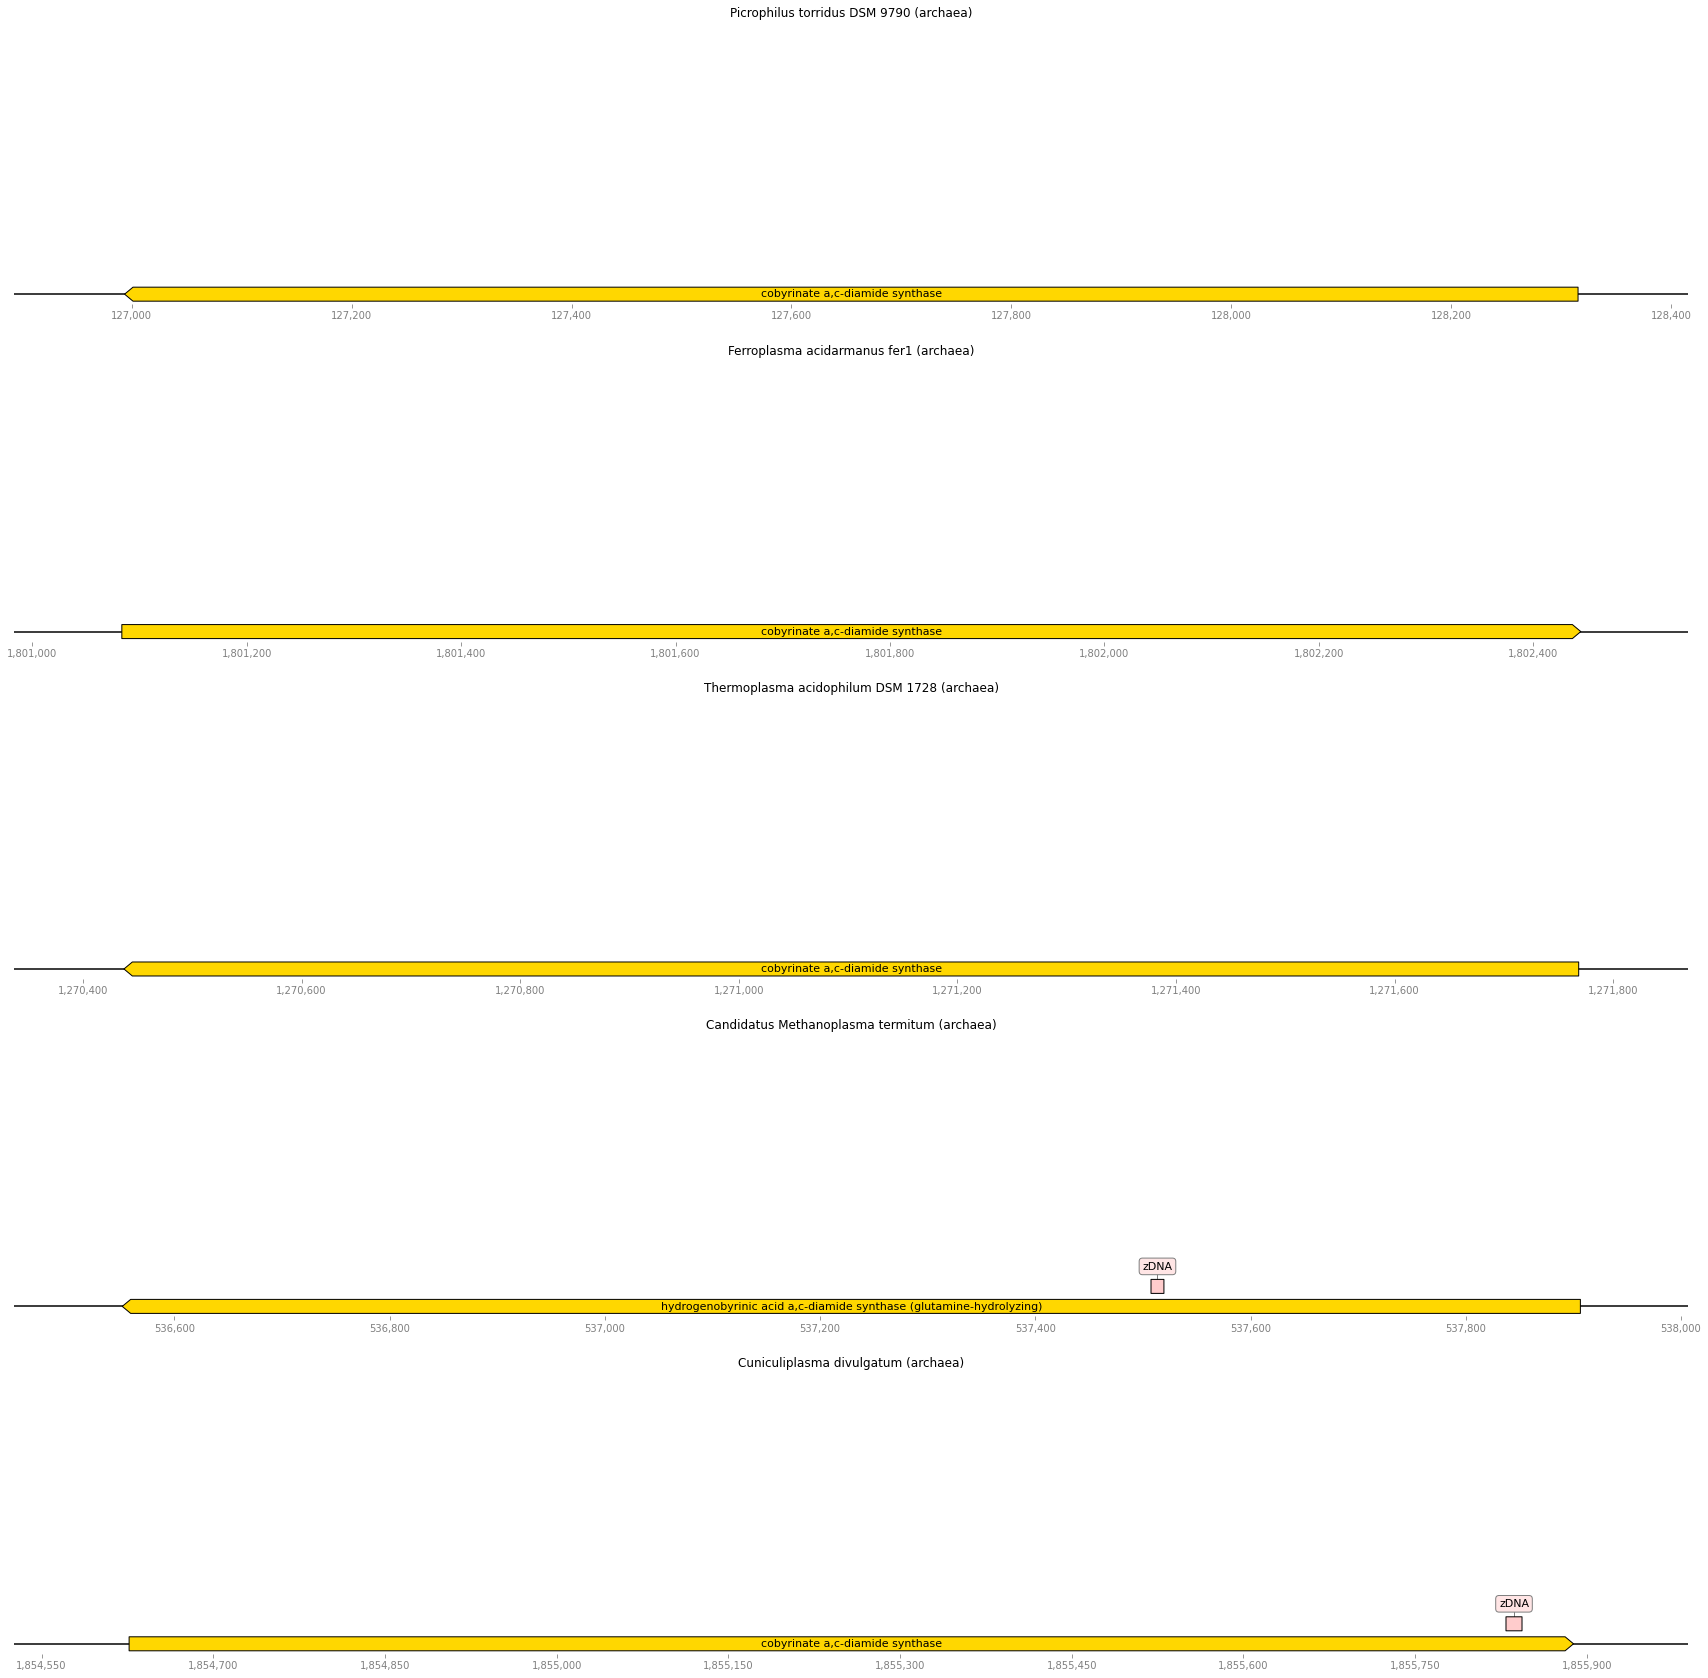

[GF(phenylalanine--tRNA ligase subunit alpha, 140553-141992 (1)), GF(zDNA, 141928-141940 )]
[GF(phenylalanine--tRNA ligase subunit alpha, 1451600-1453057 (-1))]
[GF(phenylalanine--tRNA ligase subunit alpha, 670988-672469 (-1)), GF(zDNA, 671217-671229 )]
[GF(phenylalanine--tRNA ligase subunit alpha, 952638-954158 (-1)), GF(zDNA, 953902-953914 )]
[GF(phenylalanine--tRNA ligase subunit alpha, 718661-720142 (-1)), GF(zDNA, 719954-719964 )]


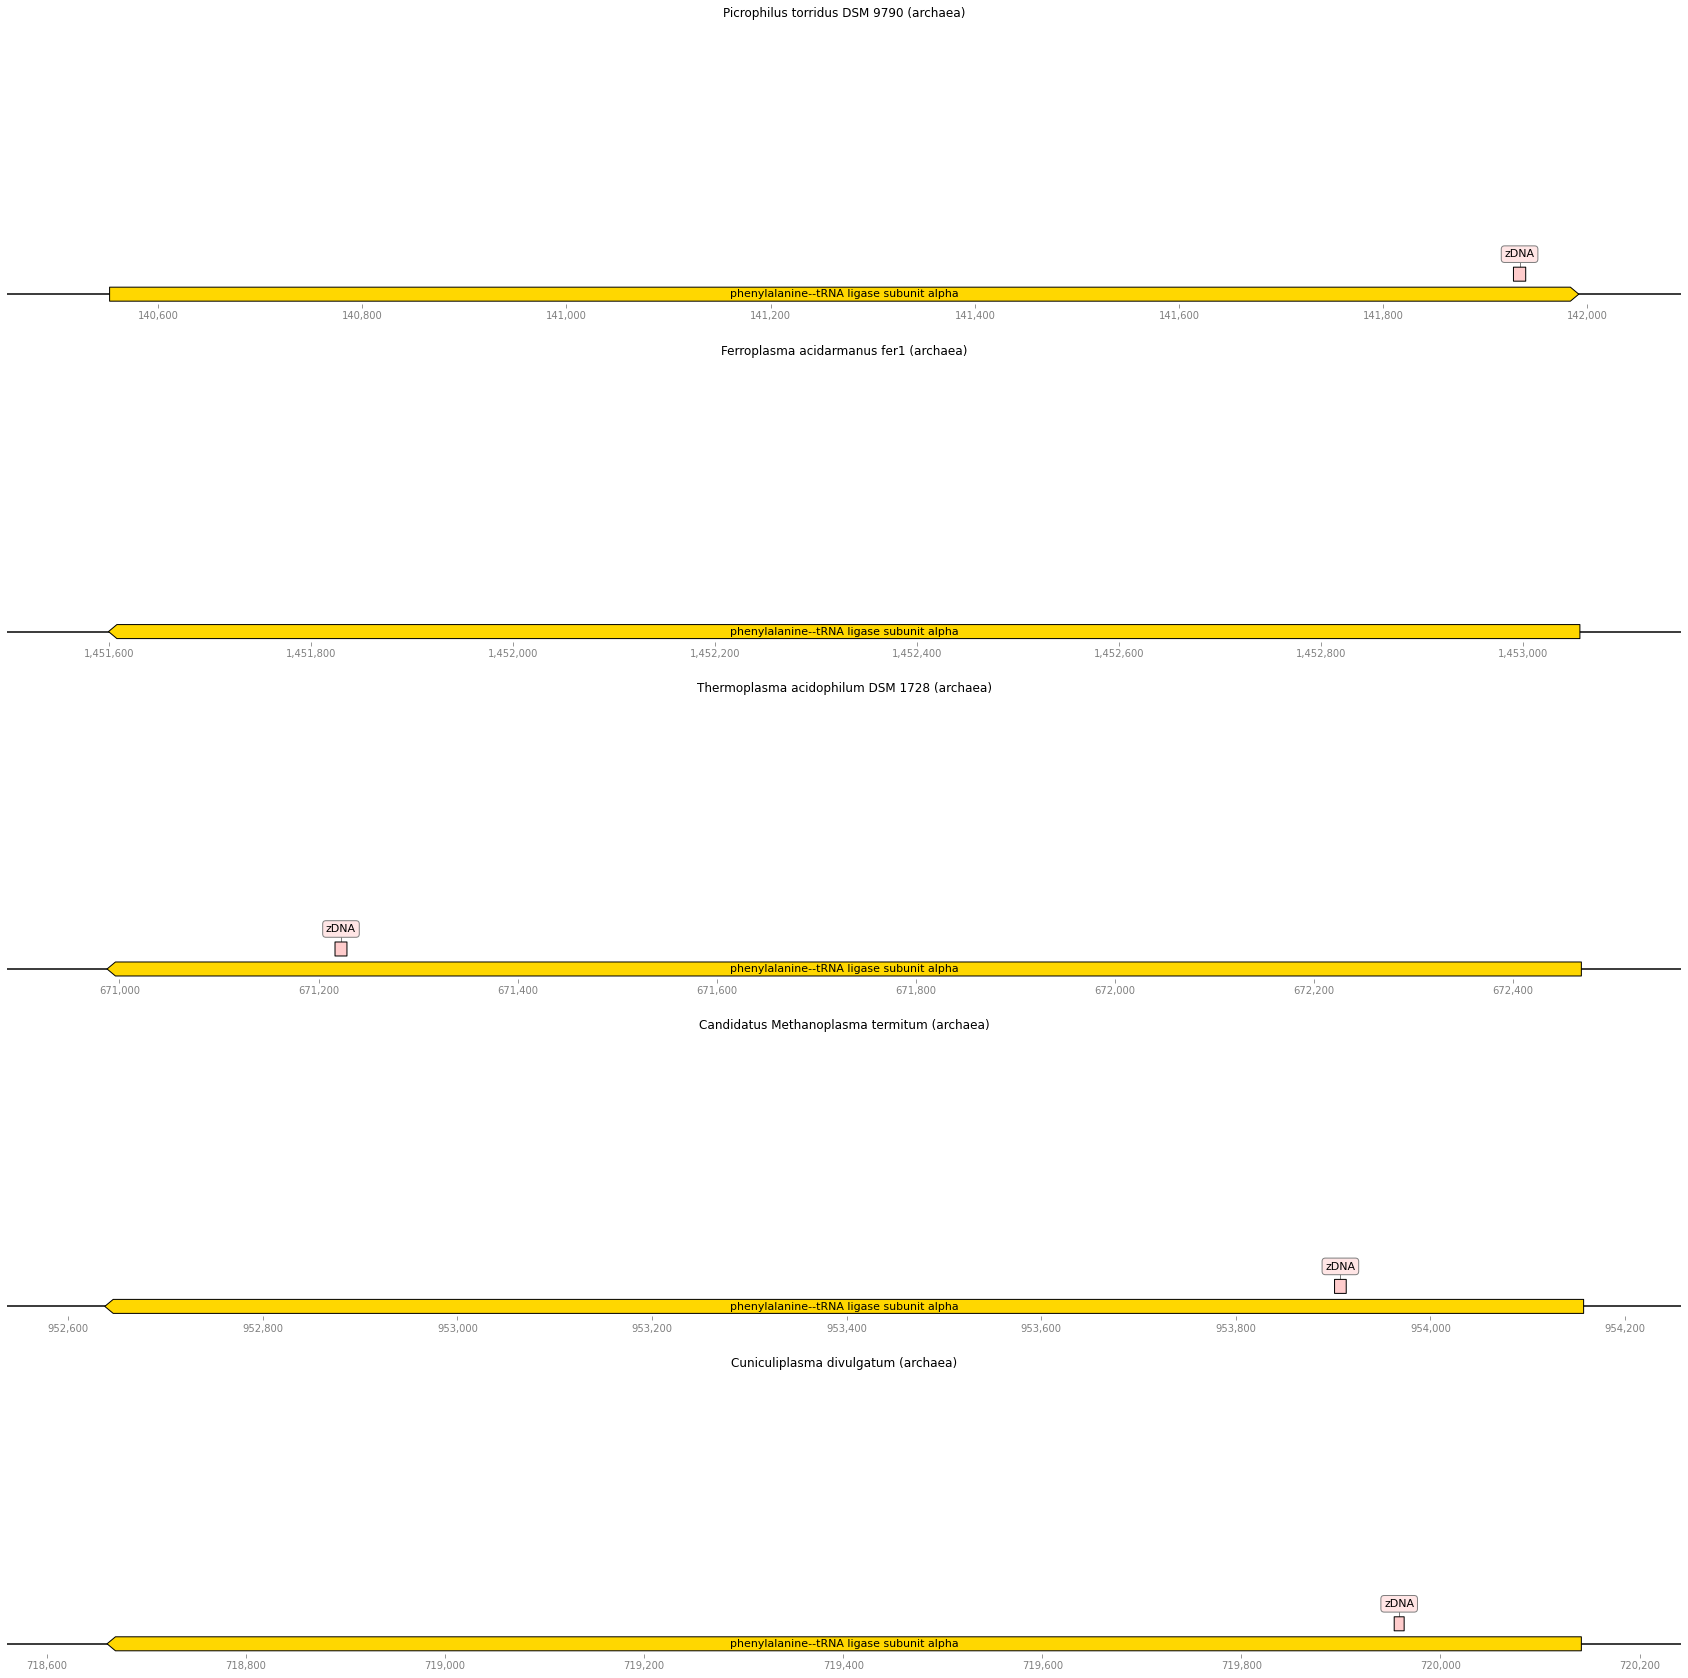

[GF(DNA polymerase II, 144053-146389 (-1))]
[GF(DNA polymerase II, 1447917-1450250 (1))]
[GF(DNA polymerase II, 977487-979877 (-1))]
[GF(DNA polymerase II, 119262-121676 (1))]
[GF(DUF1744 domain-containing protein, 490767-493145 (1))]


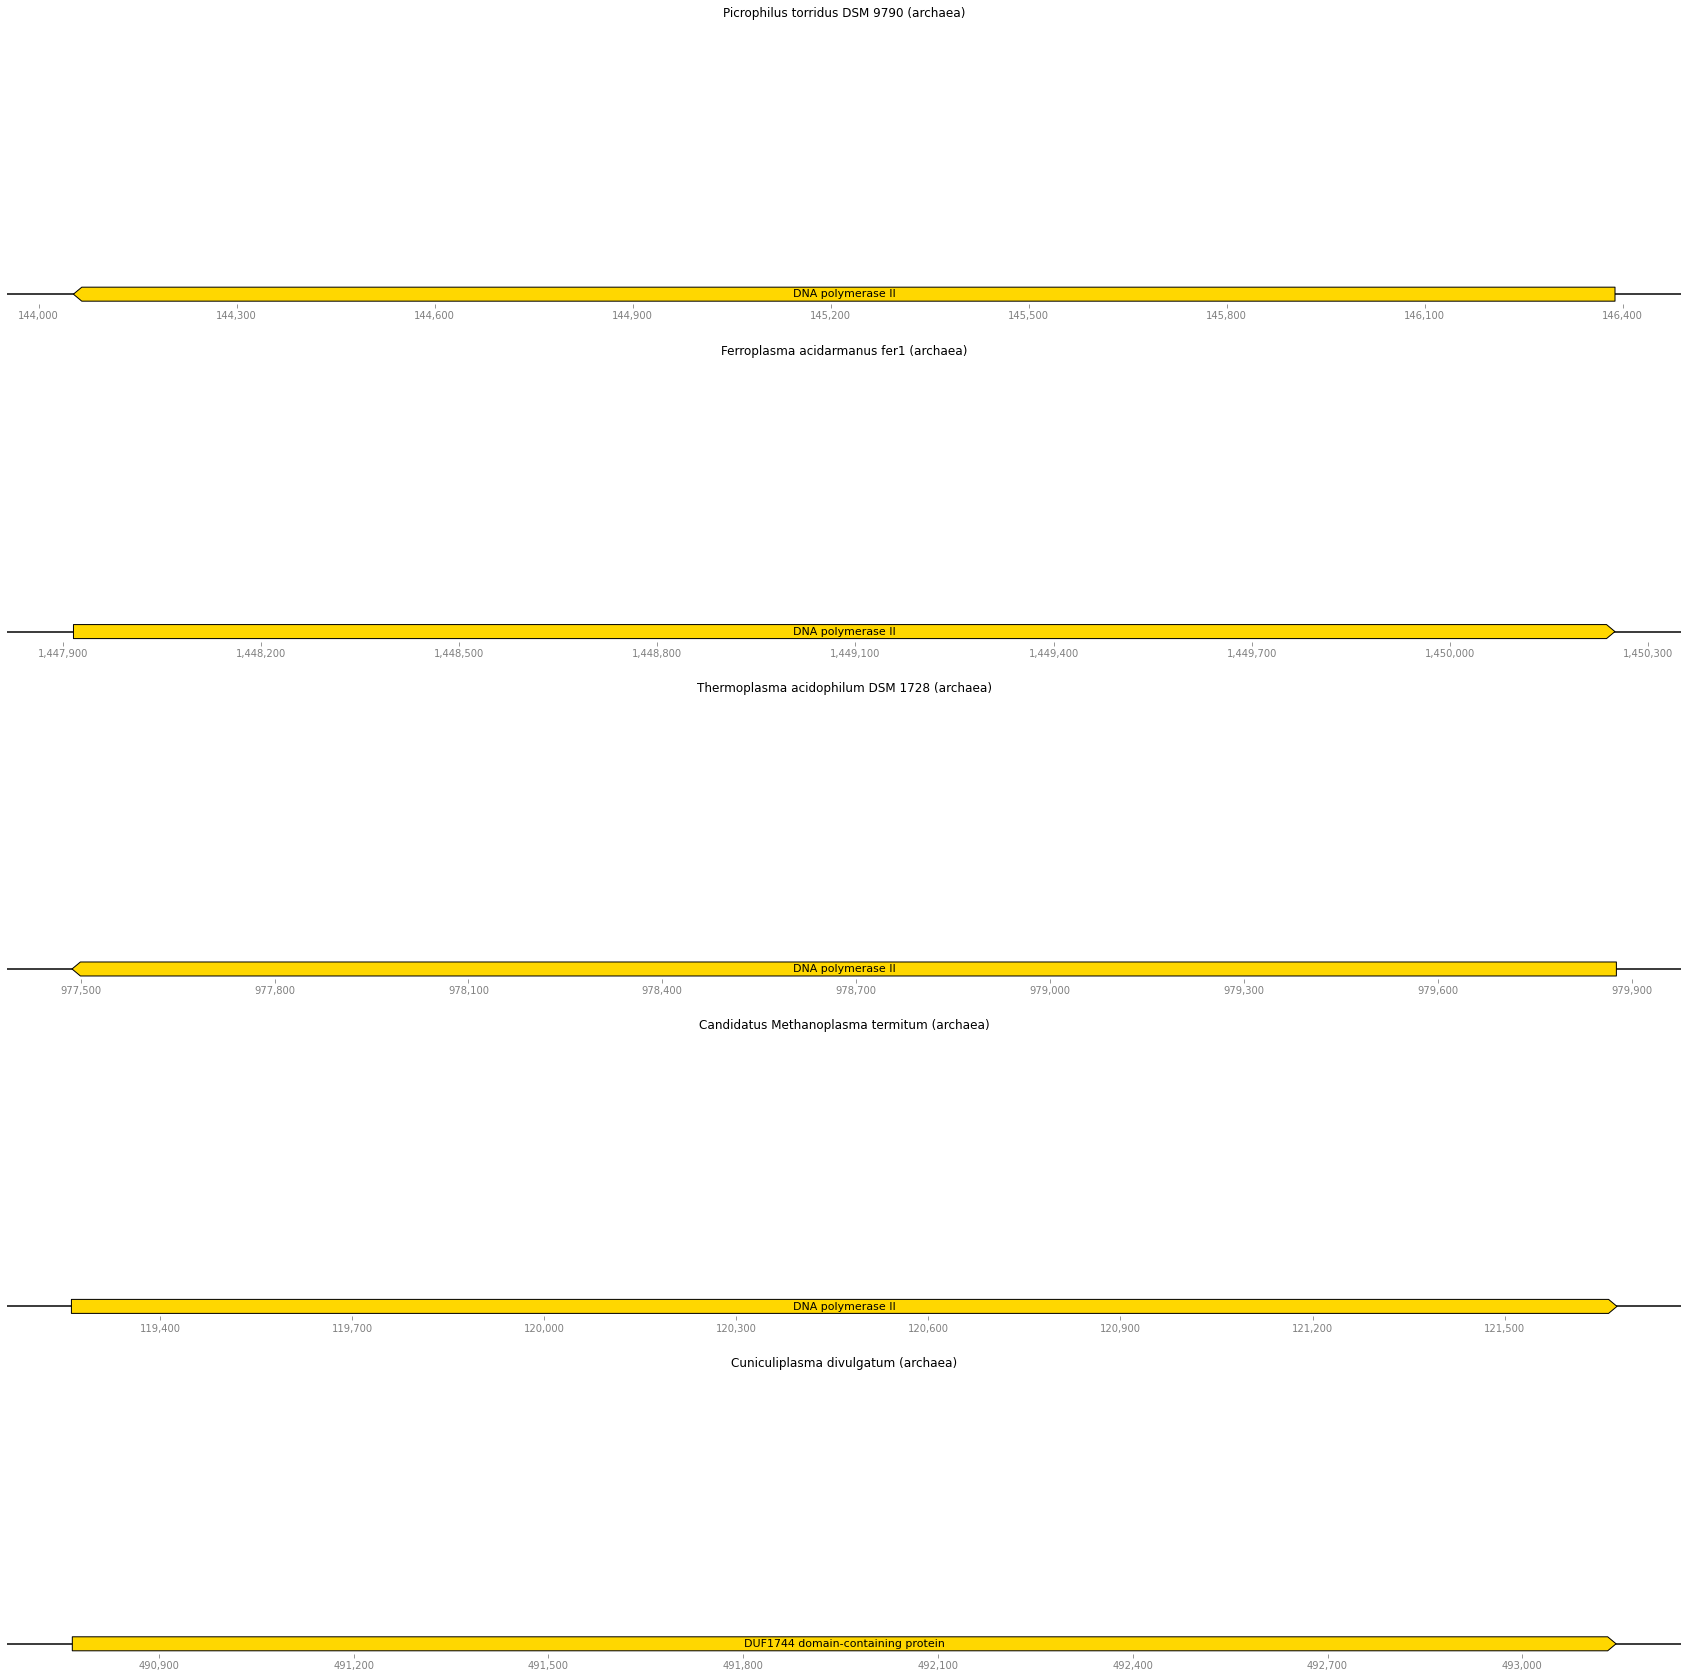

[GF(nicotinamide-nucleotide adenylyltransferase, 146506-147015 (-1))]
[GF(nicotinamide-nucleotide adenylyltransferase, 1447309-1447827 (1))]
[GF(nicotinamide-nucleotide adenylyltransferase, 815591-816133 (1))]
[GF(nicotinamide-nucleotide adenylyltransferase, 296009-296551 (-1))]
[GF(nicotinamide-nucleotide adenylyltransferase, 777772-778287 (1))]


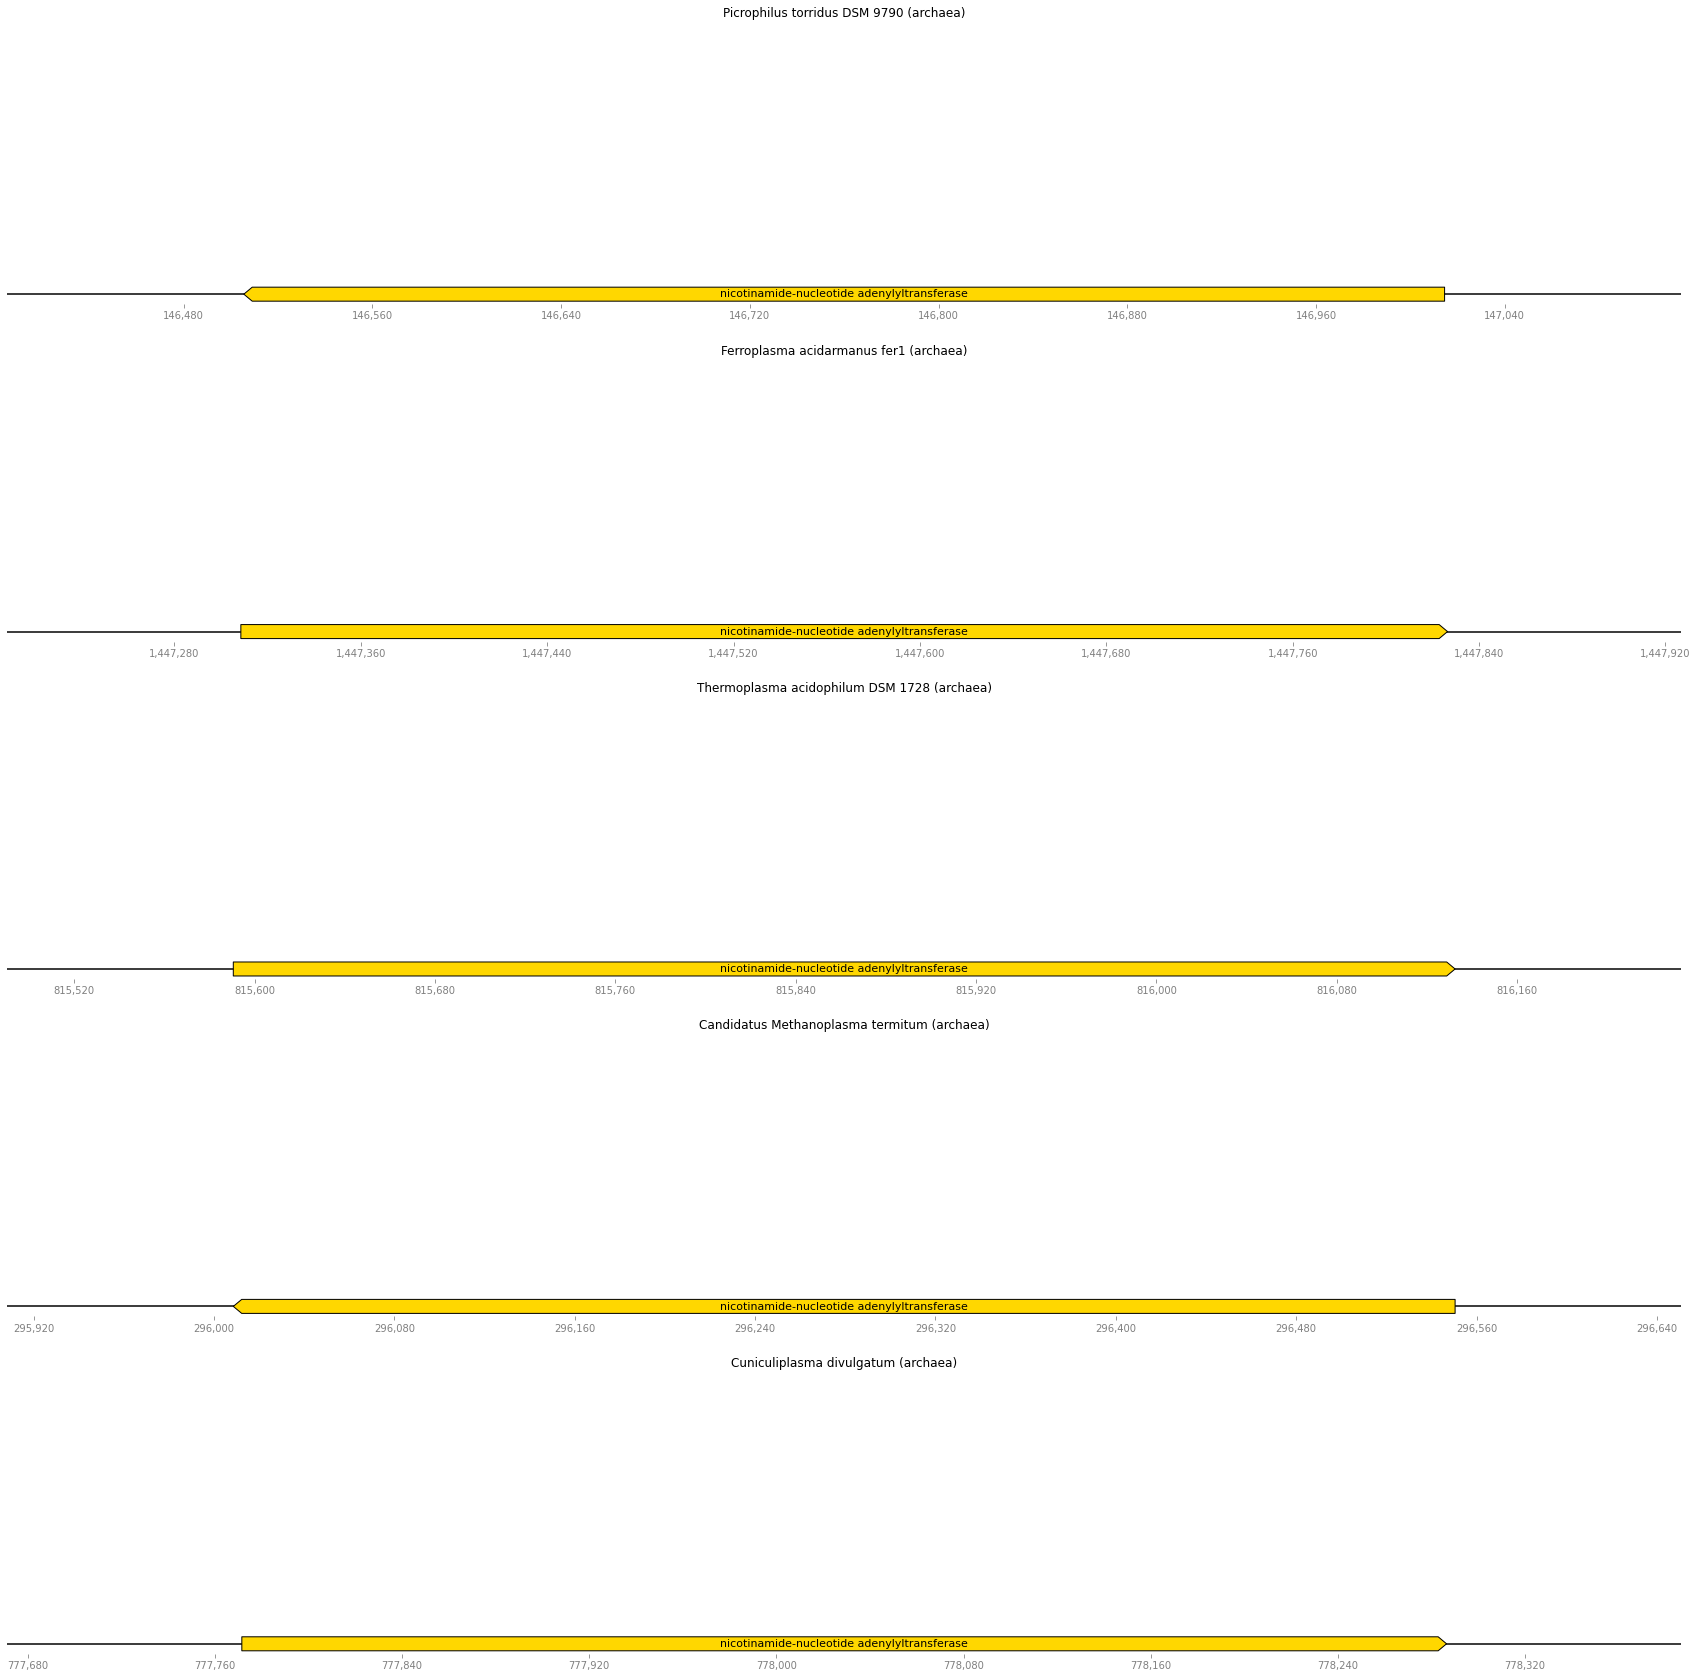

[GF(TIGR00269 family protein, 172888-173826 (-1))]
[GF(TIGR00269 family protein, 476536-477471 (1))]
[GF(TIGR00269 family protein, 1187053-1187997 (1)), GF(zDNA, 1187748-1187760 )]
[GF(TIGR00269 family protein, 690352-691173 (1))]
[GF(TIGR00269 family protein, 1846674-1847606 (-1))]


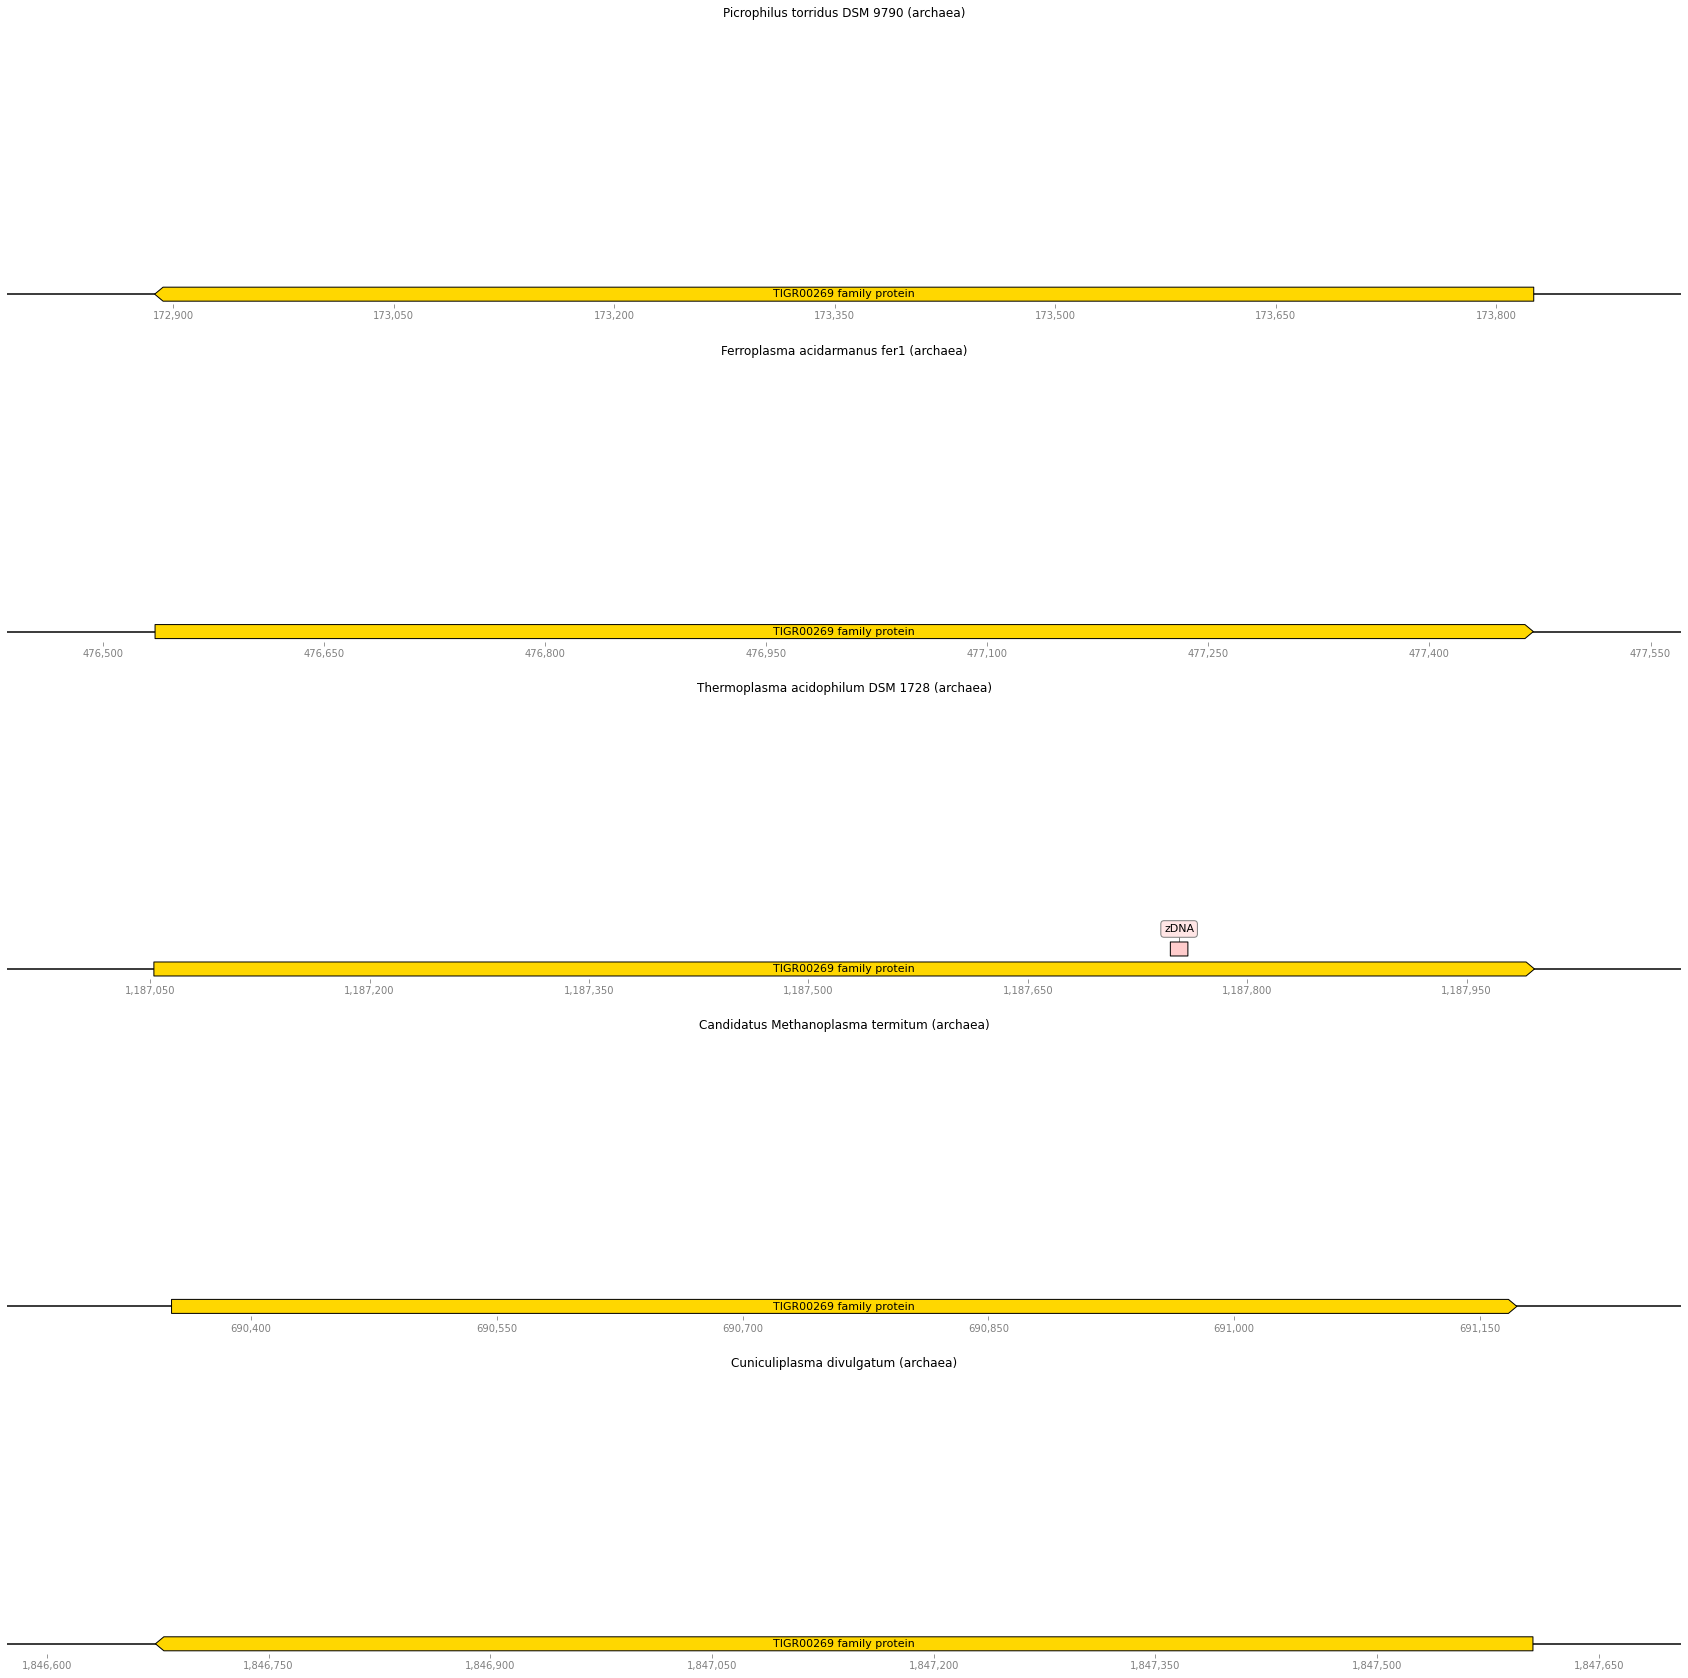

[GF(menaquinone biosynthesis decarboxylase, 191651-193087 (-1))]
[GF(menaquinone biosynthesis decarboxylase, 417918-419363 (1))]
[GF(menaquinone biosynthesis decarboxylase, 1268916-1270361 (-1))]
[GF(UbiD family decarboxylase, 732269-733540 (-1))]
[GF(menaquinone biosynthesis decarboxylase, 577356-578801 (-1))]


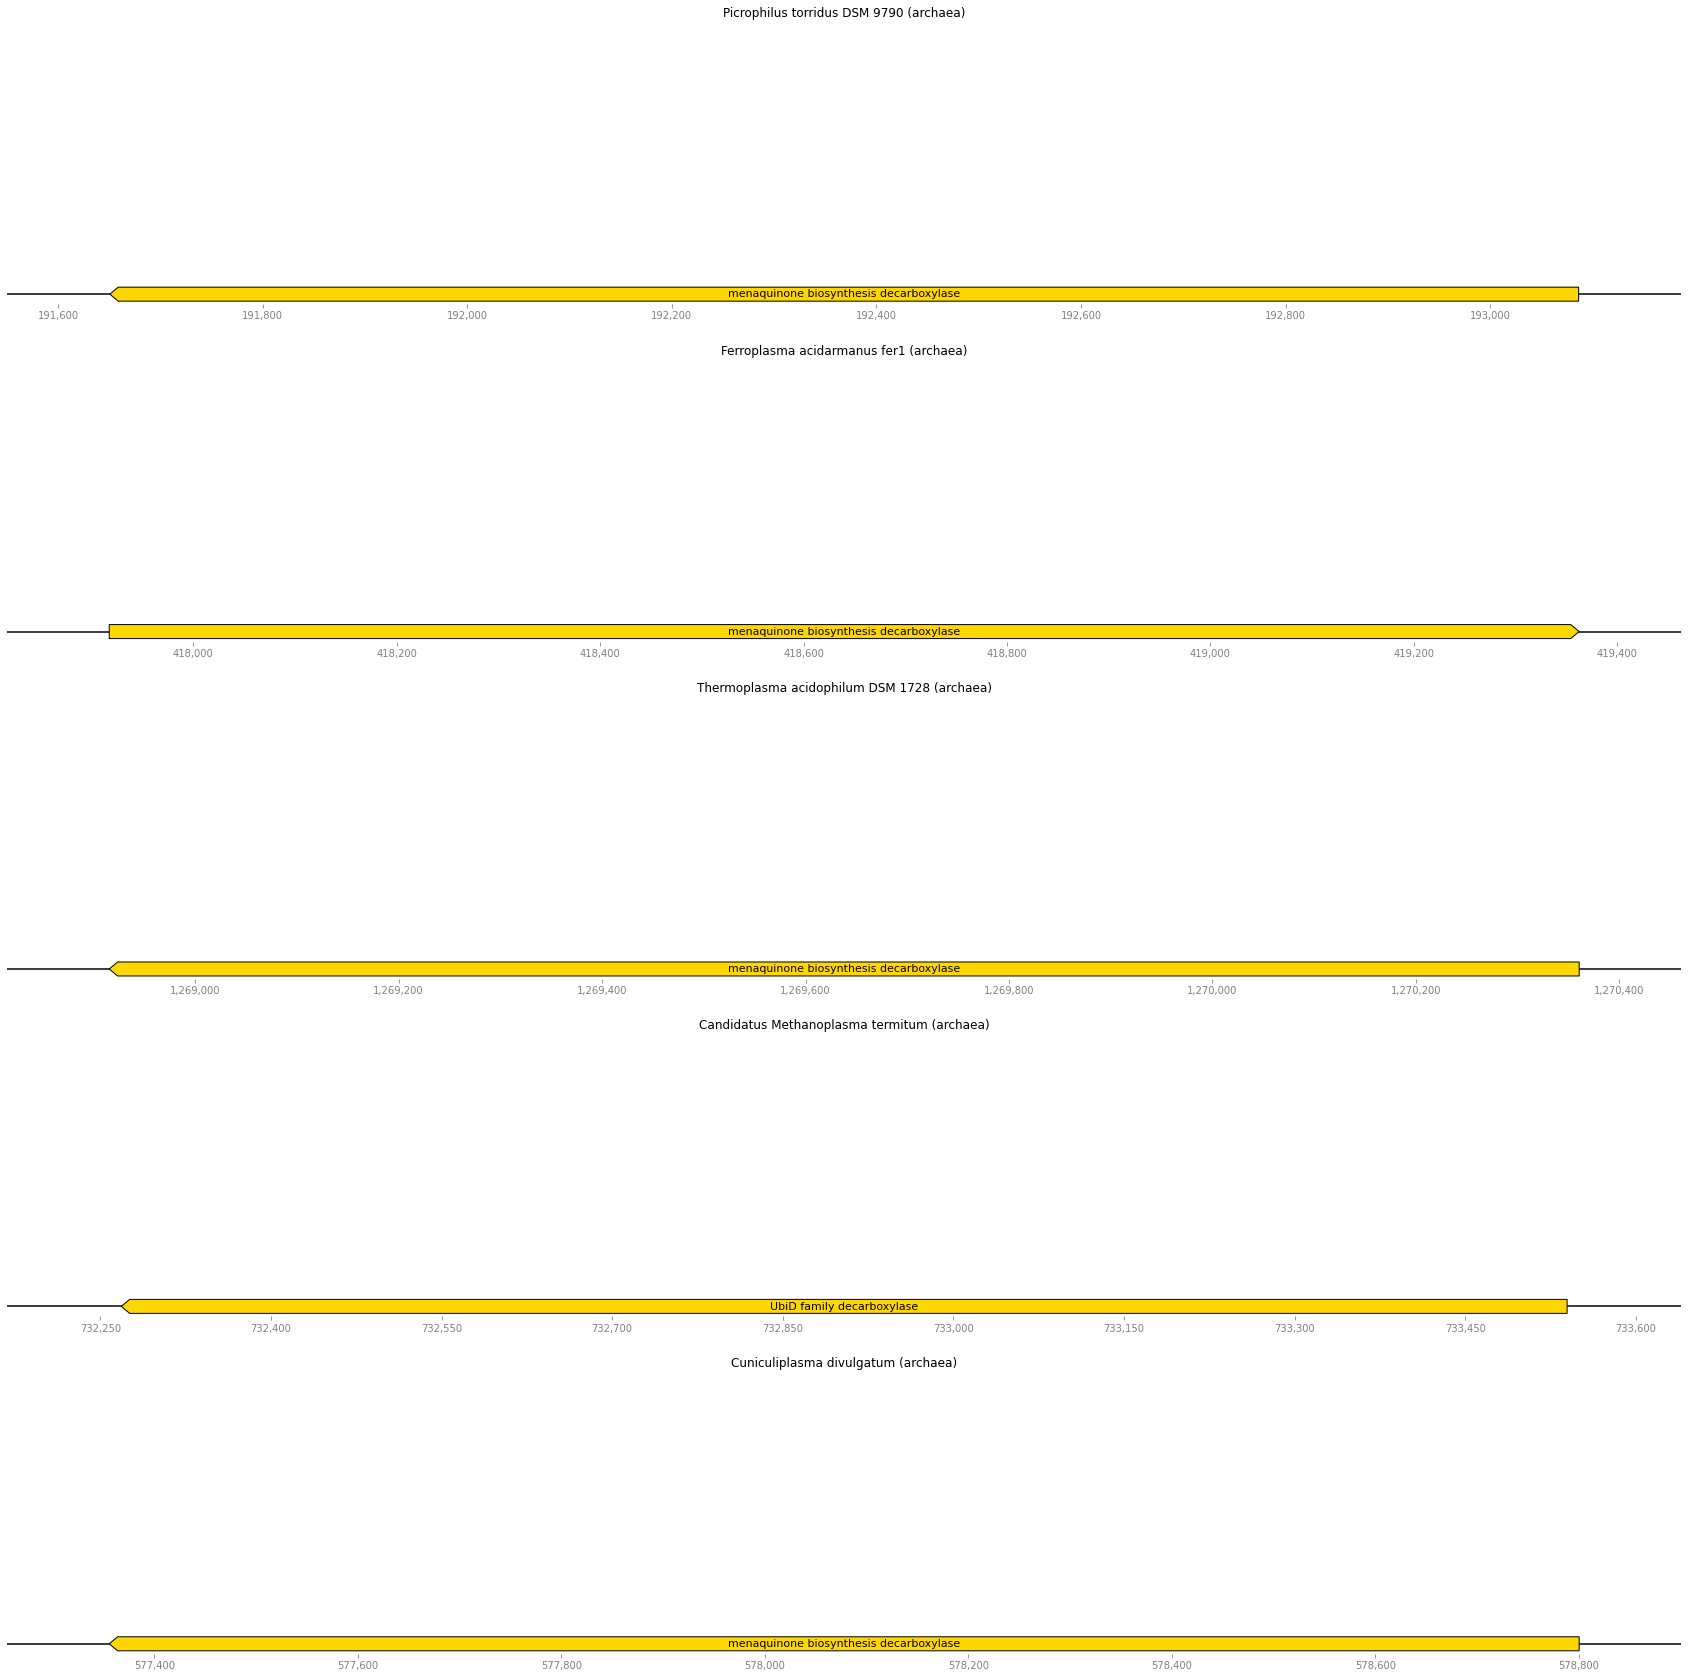

[GF(NADP-dependent isocitrate dehydrogenase, 195400-196578 (-1))]
[GF(NADP-dependent isocitrate dehydrogenase, 395565-396743 (-1))]
[GF(isocitrate dehydrogenase (NADP(+)), 110753-111970 (1))]
[GF(isocitrate/isopropylmalate family dehydrogenase, 326215-327441 (-1))]
[GF(isocitrate dehydrogenase (NADP(+)), 233503-234714 (1))]


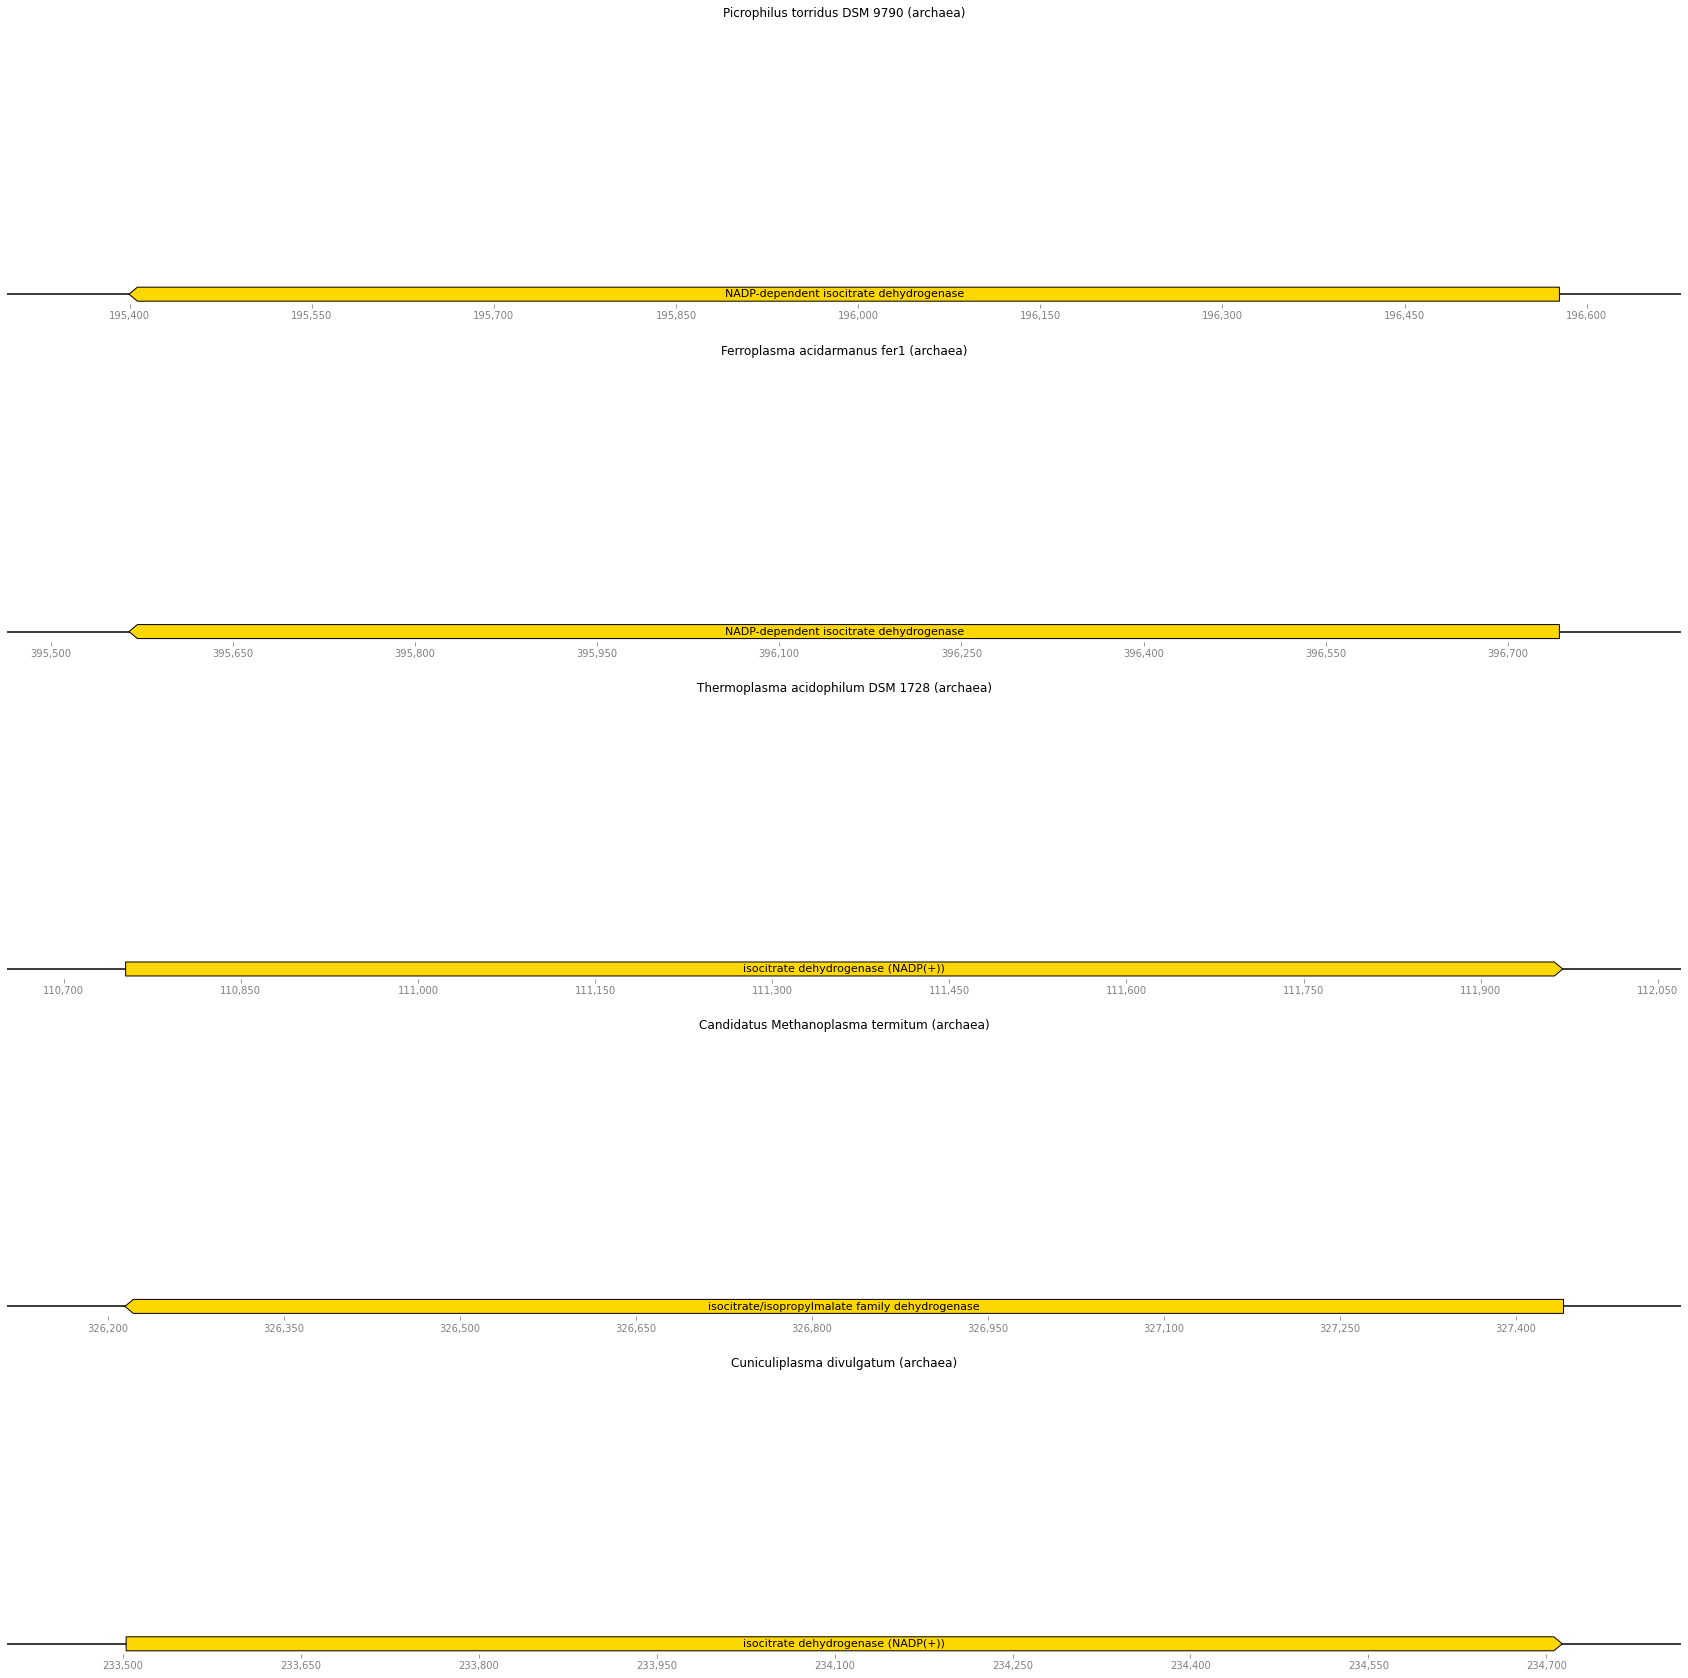

In [50]:
ac_to_id = {id_to_ac[i]:i for i in id_to_ac.keys()}
cl_nu = 0
for clus in to_vis.index:
  ert = 0
  fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(30, 30))
  for org in to_vis.columns[3:]:
    #fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 3))
    ident = org[:-15]
    gn = to_vis.loc[clus, org]
    spi = ac_to_spi[ac_to_id[ident]]
    intab = inter_frames[ac_to_id[ident]]
    gentab = beds_genes_full[ident]
    gene = list(gentab[gentab.product_accession == gn].iloc[0, [1, 2, 5, 4]])
    features=[]
    if gene[2] == '+':
      straaa = +1
    else:
      straaa = -1
    #print(gene)
    features.append(GraphicFeature(start=gene[0], end=gene[1], strand= straaa, color="#ffd700", label=gene[3]))
    conts = intab[intab.name == gn].iloc[:, [7, 8, 9]].index
    for q in conts:
      features.append(GraphicFeature(start=intab.loc[q, 'thickEnd'], end=intab.loc[q, 'itemRgb'], color="#ffcccc", label='zDNA'))
    print(features)
    record = GraphicRecord(features=features, sequence_length = gene[1]-gene[0]+200, first_index = gene[0]-100)
    ax[ert].set_title(f'{spi}')
    record.plot(ax[ert])
    ert+=1
  plt.savefig(f'{cl_nu}.png')
  plt.show()
  cl_nu += 1